# Checkerboard problem

In [1]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")

library(tidyr)
options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


Linking to GEOS 3.11.1, GDAL 3.6.2, PROJ 9.1.1; sf_use_s2() is TRUE

Lade nötiges Paket: maps


Attache Paket: ‘rnaturalearthdata’


Das folgende Objekt ist maskiert ‘package:rnaturalearth’:

    countries110


Lade nötiges Paket: abind


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Attache Paket: ‘purrr’


Das folgende Objekt ist maskiert ‘package:maps’:

    map



Attache Paket: ‘lubridate’


Das folgende Objekt ist maskiert ‘package:cowplot’:

    stamp


Die folgenden Objekte sind maskiert von ‘package:base’:

    date, intersect, setdiff, union



Attache Paket: ‘data.table’


Die folgenden Objekte sind maskiert von ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


Das folgende Objekt ist maskiert ‘package:purrr’:

    transpose


Die folgenden Objekte sind maskiert von

## The Problem:
Oscillations appear in the field of $\sigma = \sqrt{RSS/(n-p)}$. They did not appear In the original results. Differences:
1. Instead of calculating the spread, now it is downloaded directly.
2. Data is on .5 grid now. -> irrelevant
3. Models differ wrt:
- package used (nlme instead of lm) -> effectively the same
-  Autocorrelation assumed -> error persists if not assumed
- Segmentwise Variances -> error persists if not assumed

In [3]:
gls_data <- readRDS(paste0(ENS_DATA_DIR, "gls_model_summary.rds"))


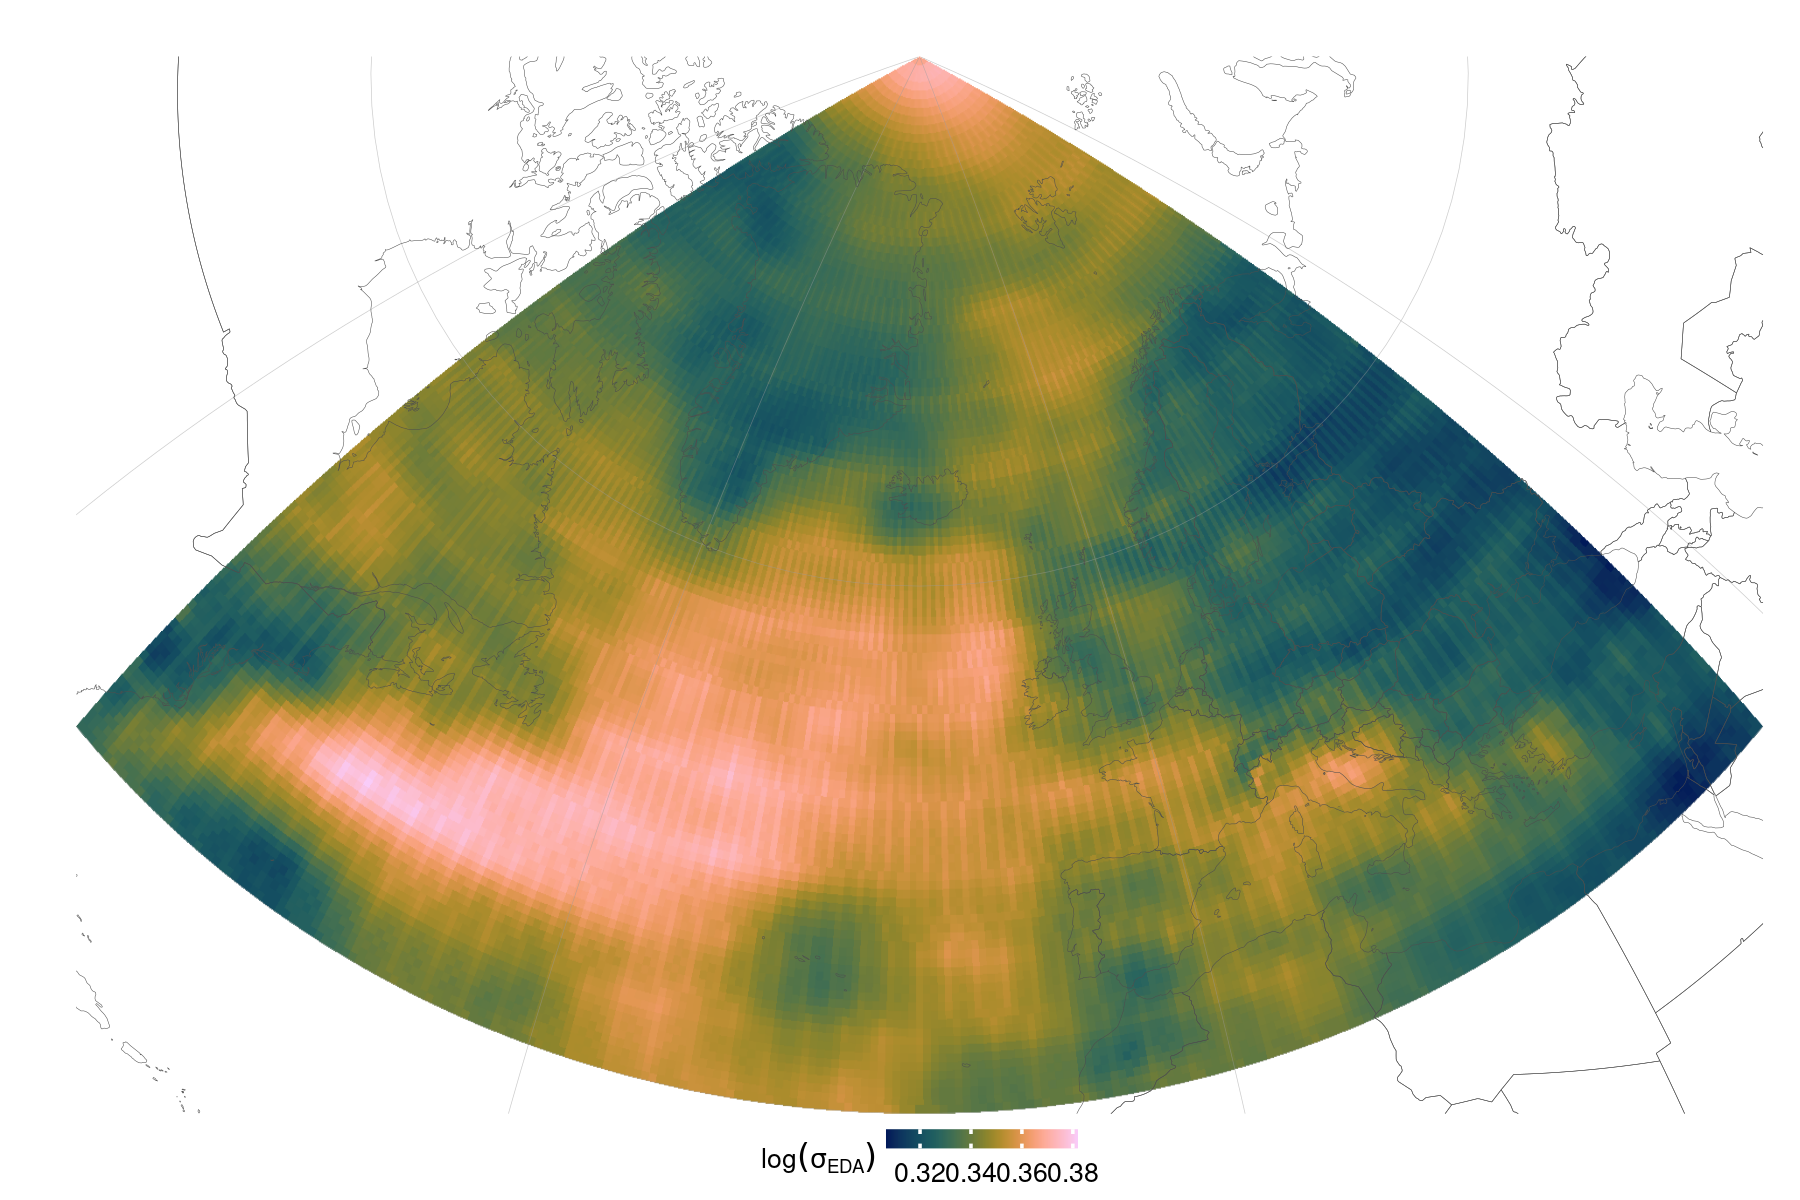

In [16]:
p <- plot_spatial(
    data = gls_data, var_name = "sigma",
    legend_name = "$\\log(\\sigma_{EDA})$",
    show_graticule_labels = FALSE
) + THEME_PUB_LARGE +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        legend.box.spacing = unit(0, "cm"), # Remove space between legend and plot
        legend.margin = margin(t = -.5, unit = "cm") # Adjust top margin if needed
    ) #+ labs(title = "Stat. Model Fit")
p


### Look at one latitude only:
- strong signal with wavelength 2.5

In [2]:
plot_trend_and_signal <- function(x, y, lat_focus, span = 0.3) {
    df <- tibble(
        lon = x,
        y   = y
    )

    trend <- loess(y ~ lon, data = df, span = span, degree = 1)

    df <- df %>%
        mutate(
            y_trend     = predict(trend),
            y_detrended = y - y_trend
        )

    p <- ggplot(df, aes(x = lon)) +
        geom_line(aes(y = y)) +
        geom_point(aes(y = y), size = 1) +
        geom_line(aes(y = y_trend), color = "red") +
        labs(
            x = "Longitude",
            y = "Sigma",
            title = paste("Latitudinal slice at", lat_focus, "°N")
        ) +
        theme_minimal()

    return(list(
        plot        = p,
        y_detrended = df$y_detrended,
        y_trend     = df$y_trend
    ))
}

plot_lon_spectrum <- function(lon, y_detrended, lat_focus,
                              max_wavelength = 40,
                              pad_factor = 4) {
    df <- tibble(
        lon = lon,
        y   = y_detrended
    ) %>%
        arrange(lon)

    y <- df$y
    n <- length(y)

    dx <- mean(diff(df$lon)) # longitude spacing (deg)

    ## --- zero-padding ---
    n_fft <- pad_factor * n
    y_pad <- c(y, rep(0, n_fft - n))

    fft_vals <- fft(y_pad)
    power <- Mod(fft_vals)^2

    freq <- (0:(n_fft - 1)) / (n_fft * dx) # cycles per degree
    wavelength <- 1 / freq

    spec_df <- tibble(
        wavelength = wavelength[2:(n_fft / 2)],
        power      = power[2:(n_fft / 2)]
    ) %>%
        filter(is.finite(wavelength), wavelength <= max_wavelength)

    p <- ggplot(spec_df, aes(x = wavelength, y = power)) +
        geom_line() +
        scale_x_reverse(limits = c(max_wavelength, 0)) +
        labs(
            x = "Wavelength (degrees longitude)",
            y = "Spectral power",
            title = paste(
                "Spatial spectrum (<", max_wavelength,
                "°) at", lat_focus, "°N"
            )
        ) +
        theme_minimal()

    return(list(
        spectrum = spec_df,
        plot     = p
    ))
}

grid_scale_spectral_test <- function(y,
                                     dx = 0.5,
                                     grid_multiples = 1:10,
                                     detrended = TRUE) {
    y <- as.numeric(y)
    y <- y[is.finite(y)]

    N <- length(y)
    if (N < 10) stop("Time series too short for spectral test")

    ## --- FFT-based spectrum ---
    fft_y <- fft(y)
    power <- Mod(fft_y)^2 / N
    power <- power[1:floor(N / 2)]

    freq <- (0:(length(power) - 1)) / (N * dx)
    wavelength <- 1 / freq

    ## --- AR(1) null spectrum ---
    phi_hat <- acf(y, lag.max = 1, plot = FALSE)$acf[2]

    S_ar1 <- function(freq, phi, sigma2 = 1) {
        sigma2 / (1 + phi^2 - 2 * phi * cos(2 * pi * freq * dx))
    }

    spec_null <- S_ar1(freq, phi_hat)

    ## normalize null to observed total power
    spec_null <- spec_null * sum(power, na.rm = TRUE) /
        sum(spec_null, na.rm = TRUE)

    ## --- grid-scale wavelengths ---
    grid_wavelengths <- dx * grid_multiples

    idx <- sapply(grid_wavelengths, function(wl) {
        which.min(abs(wavelength - wl))
    })

    obs_power <- power[idx]
    null_power <- spec_null[idx]

    power_ratio <- obs_power / null_power

    ## χ²₂ / 2 ⇒ exponential tail
    p_values <- exp(-power_ratio)

    grid_test <- tibble(
        wavelength = grid_wavelengths,
        power_obs  = obs_power,
        power_null = null_power,
        ratio      = power_ratio,
        p_value    = p_values,
        p_adj      = p.adjust(p_values, method = "fdr")
    )

    p <- ggplot() +
        geom_line(aes(wavelength, power), color = "black") +
        geom_line(aes(wavelength, spec_null), linetype = "dashed") +
        geom_vline(xintercept = grid_wavelengths, color = "red", alpha = 0.4) +
        scale_x_reverse(limits = c(10, 0.5)) +
        labs(
            x = "Wavelength (degrees)",
            y = "Power",
            title = "Grid-scale artefact test (AR(1) null)"
        ) +
        theme_minimal()
    print(p)
    return(grid_test)
}

extract_ss <- function(fpath) {
    fname <- basename(fpath)
    # Extract numbers from filename (assumes pattern lm<lat>_<lon>.Rds)
    nums <- stringr::str_extract_all(fname, "-?\\d+\\.?\\d*")[[1]]
    lat <- as.numeric(nums[1])
    lon <- as.numeric(nums[2])

    mod <- readRDS(fpath)

    y <- as.numeric(model.response(model.frame(mod)))
    res <- as.numeric(residuals(mod, type = "response"))

    RSS <- sum(res^2, na.rm = TRUE)
    TSS <- sum((y - mean(y, na.rm = TRUE))^2, na.rm = TRUE)
    ESS <- TSS - RSS

    tibble(
        lon = lon,
        lat = lat,
        RSS = RSS,
        TSS = TSS,
        ESS = ESS
    )
}

process_grid_point_gls <- function(lat, lon, z, time, cps) {
    z_df <- data.frame(time = time, z = z)
    z_df$year <- as.integer(format(z_df$time, "%Y"))
    z_df$doy <- as.integer(format(z_df$time, "%j"))
    z_df$sin_doy <- sin(2 * pi * z_df$doy / 365)
    z_df$cos_doy <- cos(2 * pi * z_df$doy / 365)
    z_df$log_variance <- log(z_df$z)

    z_df$segment <- cut(as.Date(z_df$time),
        breaks = c(as.Date(c(
            z_df$time[1],
            cps,
            z_df$time[nrow(z_df)]
        ))),
        labels = 0:(length(cps)) + 1,
        include.lowest = TRUE,
        right = FALSE
    )
    z_df <- z_df %>%
        group_by(segment) %>%
        mutate(day_no = row_number()) %>%
        ungroup()

    lmod_seas <- nlme::gls(
        log_variance ~ segment +
            segment:year + segment:sin_doy + segment:cos_doy - 1,
        data = z_df,
        correlation = corAR1(form = ~ day_no | segment),
        weights = varIdent(form = ~ 1 | segment)
    )
    saveRDS(lmod_seas, file = paste0(
        ENS_DATA_DIR, "checkermods/lm", lat, "_", lon,
        ".Rds"
    ))
}


In [4]:
# Specify the latitude of interest
lat_focus <- 30 # example: 50°N
tolerance <- 0.25 # allow for small rounding differences in grid

# Extract slice of data at that latitude
lat_slice <- gls_data %>%
    filter(abs(lat - lat_focus) <= tolerance)

res <- plot_trend_and_signal(
    x = lat_slice$lon,
    y = lat_slice$sigma,
    lat_focus = lat_focus,
    span = 0.3
)

lat_slice$y_detrended <- res$y_detrended
lat_slice$y_trend <- res$y_trend

res$plot


ERROR: Error in filter(., abs(lat - lat_focus) <= tolerance): Objekt 'gls_data' nicht gefunden


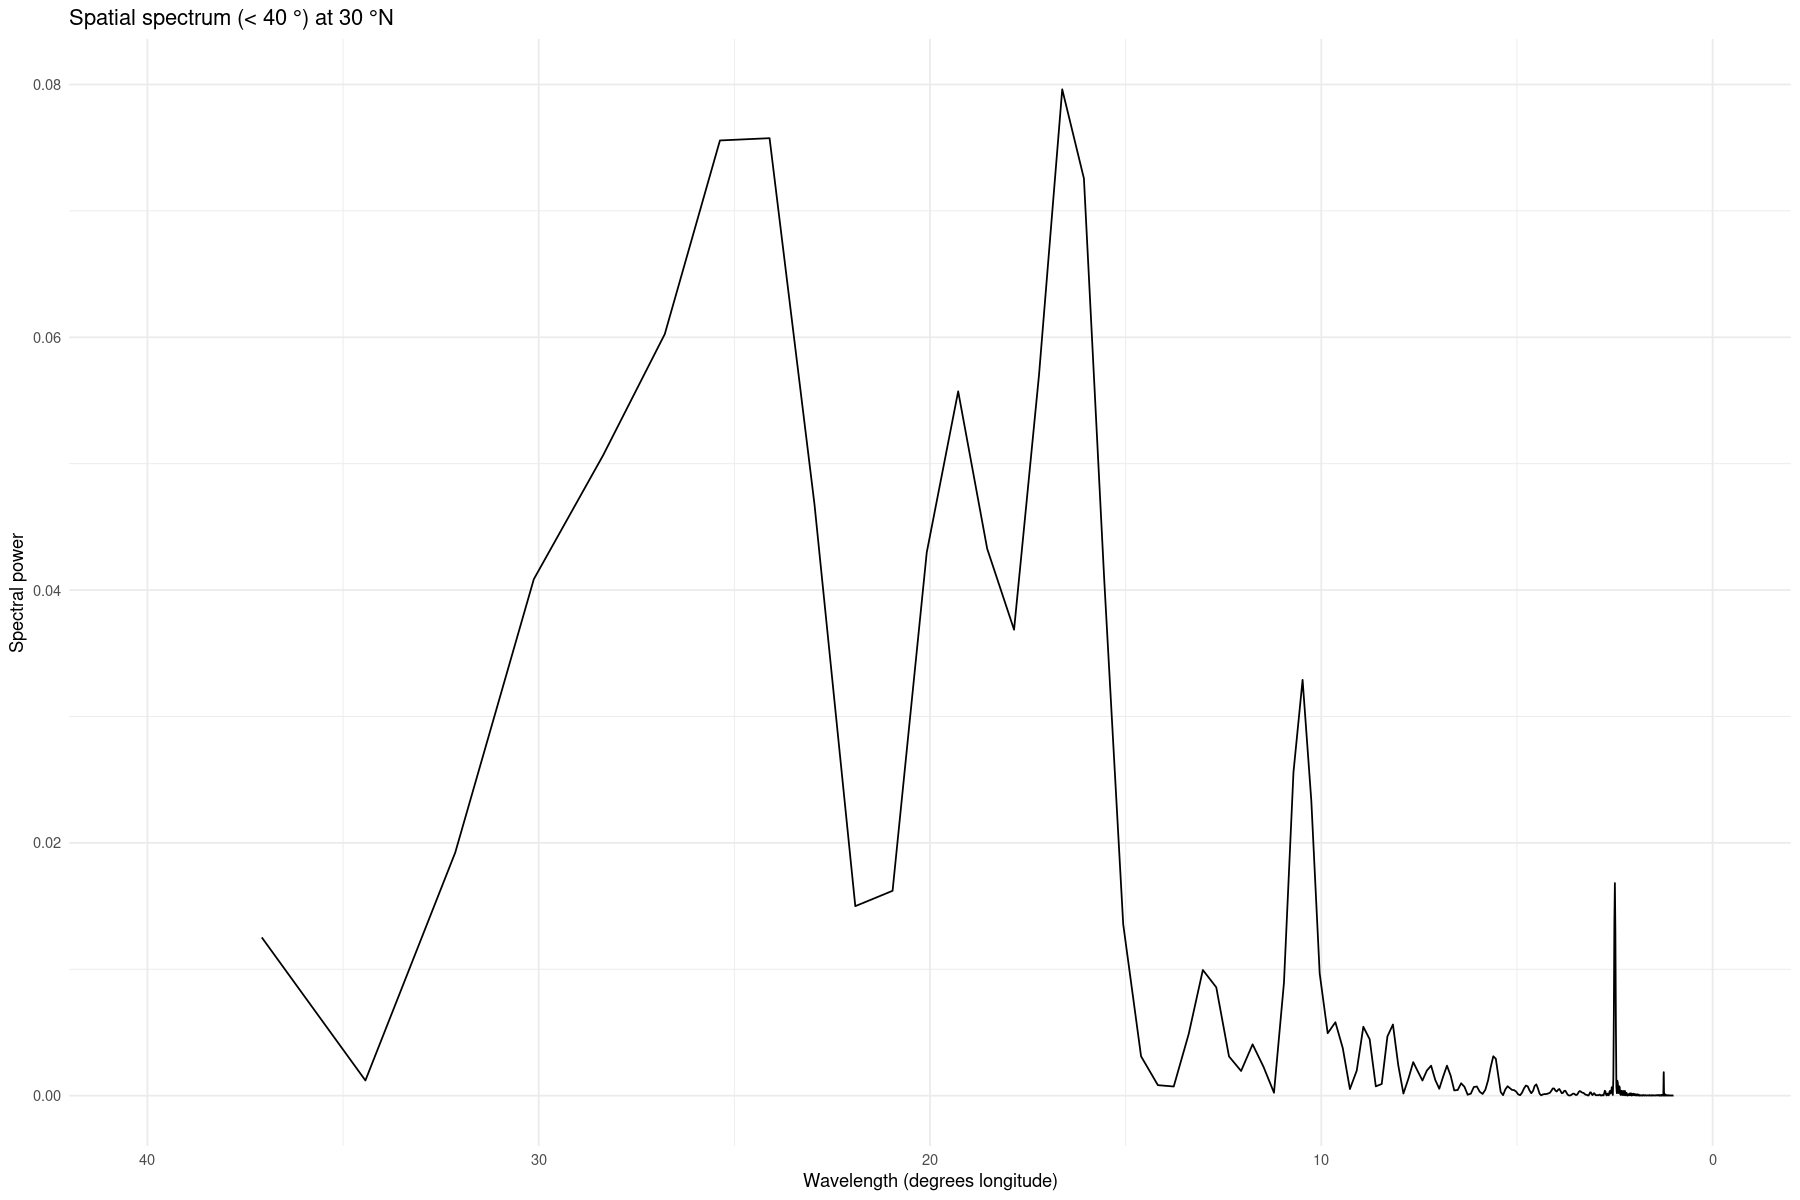

In [68]:
lat_slice <- lat_slice %>% arrange(lon)

spec_res <- plot_lon_spectrum(
    lon = lat_slice$lon,
    y_detrended = lat_slice$y_detrended,
    lat_focus = lat_focus,
    max_wavelength = 40,
    pad_factor = 4
)

spec_res$plot


Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_line()`).”


wavelength power_obs    power_null   ratio      p_value      p_adj       
1  0.5        5.879903e-08 3.971502e-07  0.1480524 8.623859e-01 8.623859e-01
2  1.0        5.879903e-08 3.971502e-07  0.1480524 8.623859e-01 8.623859e-01
3  1.5        1.450456e-07 5.317869e-07  0.2727513 7.612821e-01 8.623859e-01
4  2.0        4.523711e-07 7.982204e-07  0.5667246 5.673808e-01 8.623859e-01
5  2.5        5.685297e-05 1.154687e-06 49.2366976 4.137842e-22 4.137842e-21
6  3.0        6.225836e-07 1.594133e-06  0.3905469 6.766867e-01 8.623859e-01
7  3.5        6.621355e-07 2.147081e-06  0.3083887 7.346297e-01 8.623859e-01
8  4.0        1.655333e-06 2.712886e-06  0.6101744 5.432561e-01 8.623859e-01
9  4.5        2.328215e-06 3.310521e-06  0.7032777 4.949603e-01 8.623859e-01
10 5.0        1.335866e-06 4.142733e-06  0.3224601 7.243648e-01 8.623859e-01

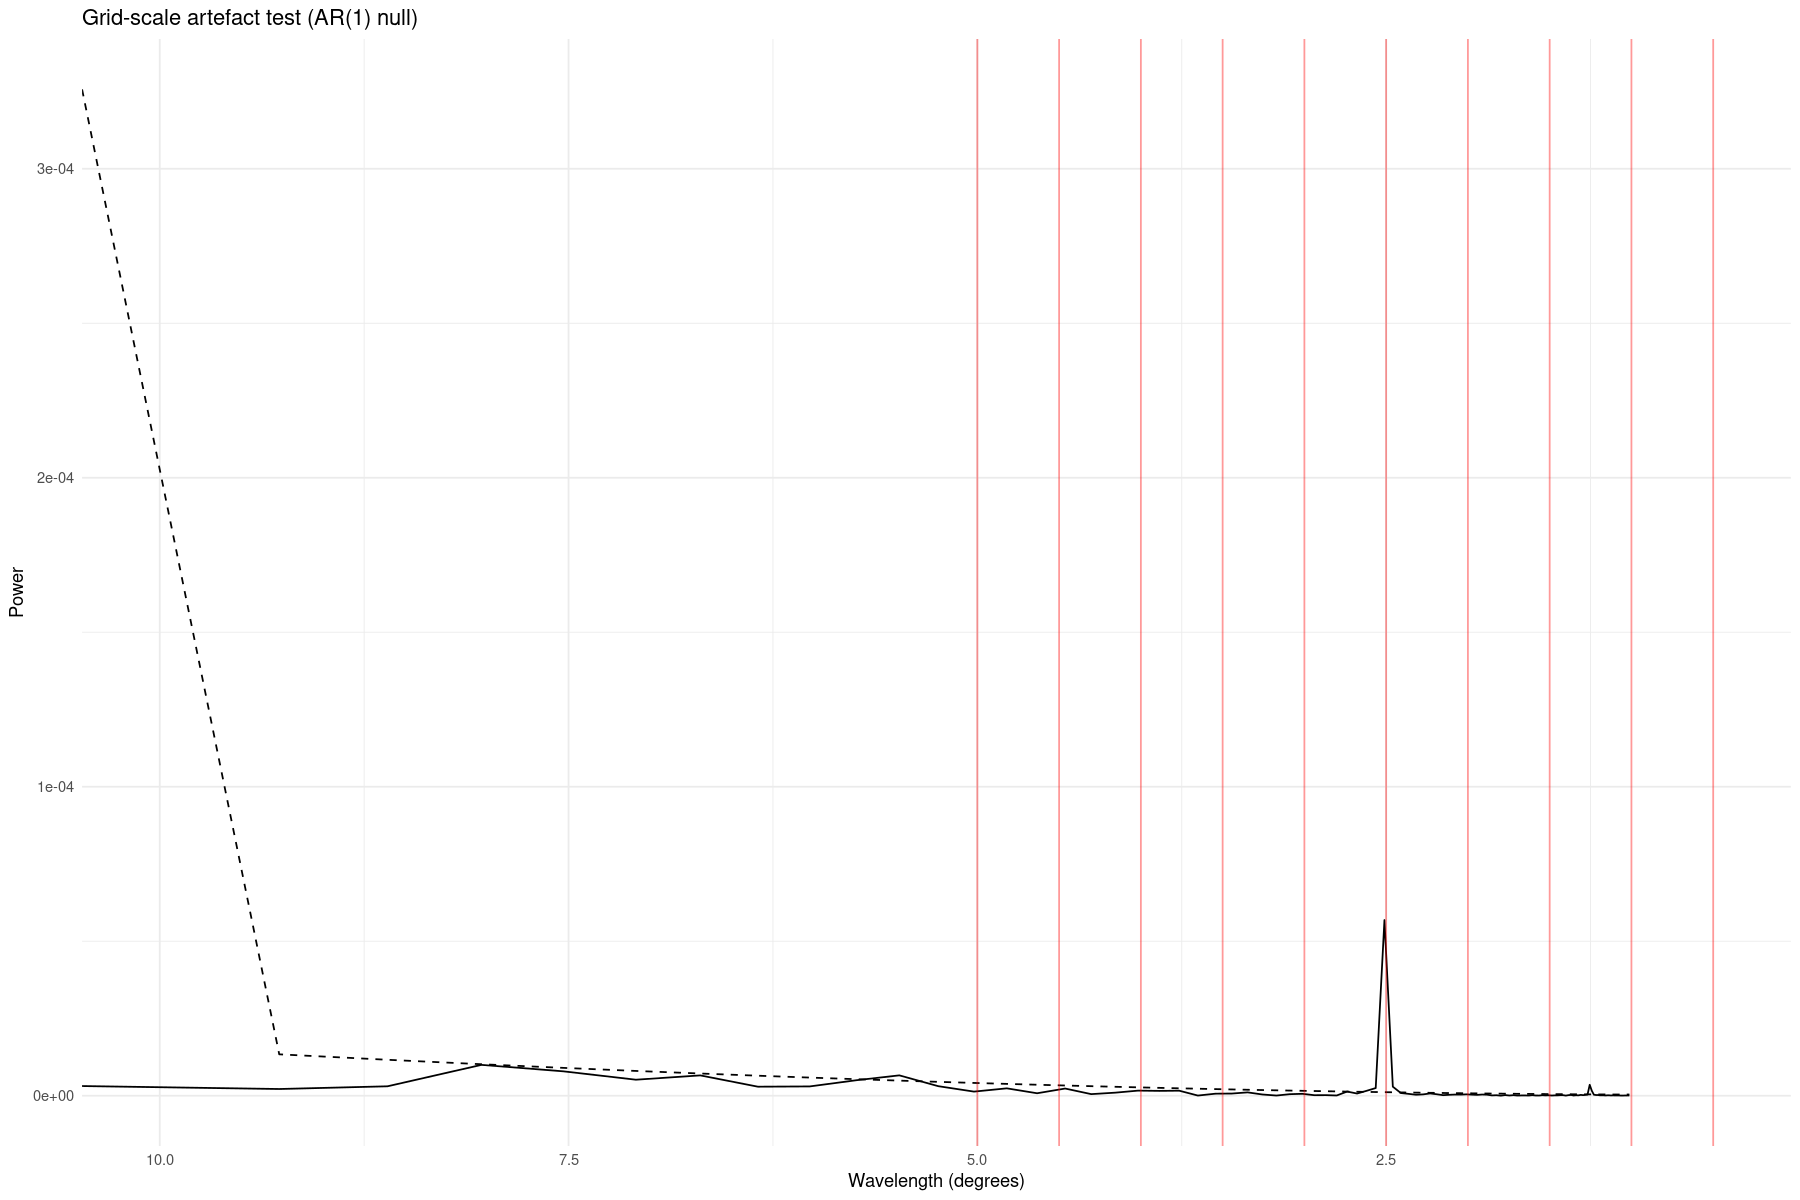

In [69]:
grid_test <- grid_scale_spectral_test(
    y  = lat_slice$y_detrended,
    dx = 0.5
)

grid_test


### Reproduce

In [3]:
nc_file <- nc_open(paste0(ENS_DATA_DIR, "geopotential.nc"))
z_data <- ncvar_get(nc_file, "z", collapse_degen = FALSE)

lon_data <- ncvar_get(nc_file, "longitude")
lat_data <- ncvar_get(nc_file, "latitude")
time_data <- ncvar_get(nc_file, "valid_time")

# Convert time
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc_file, "valid_time", "units")$value
)
time <- as.Date(as.POSIXct(time_data, origin = time_origin, tz = "UTC"))

nc_close(nc_file)
change_points <- as.Date(paste0(CP, "-01"), format = "%Y-%m-%d")


In [5]:
lat_idx <- which.min(abs(lat_data - lat_focus))

# subset without collapsing other axes
z_lat <- z_data[, lat_idx, , drop = FALSE]
grid_points <- expand.grid(1:length(lon_data), lat_idx)
# grid_points <- expand.grid(1:8, lat_idx)


In [ ]:
library(parallel)

n_cores <- 8

parallel::mclapply(
    seq_len(nrow(grid_points)),
    function(i) {
        lon_idx <- grid_points[i, 1]
        lat_idx <- grid_points[i, 2]

        file_path <- paste0(
            ENS_DATA_DIR, "checkermods/lm",
            lat_data[lat_idx], "_", lon_data[lon_idx],
            ".Rds"
        )

        process_grid_point_gls(
            lat_data[lat_idx],
            lon_data[lon_idx],
            z_data[lon_idx, lat_idx, ],
            time,
            change_points
        )

        NULL
    },
    mc.cores = n_cores
)


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

In [18]:
test_mod <- readRDS(paste0(ENS_DATA_DIR, "checkermods/lm30_-77.Rds"))
compare_mod <- readRDS(paste0(ENS_DATA_DIR, "checkermods_curta/lm30_-77.Rds"))


In [20]:
summary(test_mod)
summary(compare_mod)


Generalized least squares fit by REML
  Model: log_variance ~ segment + segment:year + segment:sin_doy + segment:cos_doy -      1 
  Data: z_df 
      AIC      BIC    logLik
  19071.4 19330.01 -9504.699

Correlation Structure: AR(1)
 Formula: ~day_no | segment 
 Parameter estimate(s):
      Phi 
0.1970689 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment 
 Parameter estimates:
        1         2         3         4         5         6 
1.0000000 0.9619529 0.9769736 1.0236609 1.0817524 1.1725090 

Coefficients:
                     Value Std.Error   t-value p-value
segment1         216.08008  5.443223  39.69708  0.0000
segment2          37.69784  5.045679   7.47131  0.0000
segment3          18.16142  1.369071  13.26550  0.0000
segment4          16.69102  1.697703   9.83153  0.0000
segment5          31.20224  4.602833   6.77892  0.0000
segment6           7.70632  2.643463   2.91524  0.0036
segment1:year     -0.10926  0.002800 -39.01823  0.0

Generalized least squares fit by REML
  Model: log_variance ~ segment + segment:year + segment:sin_doy + segment:cos_doy -      1 
  Data: z_df 
      AIC      BIC    logLik
  19071.4 19330.01 -9504.699

Correlation Structure: AR(1)
 Formula: ~day_no | segment 
 Parameter estimate(s):
      Phi 
0.1970693 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment 
 Parameter estimates:
        1         2         3         4         5         6 
1.0000000 0.9619572 0.9769681 1.0236654 1.0817475 1.1725094 

Coefficients:
                     Value Std.Error   t-value p-value
segment1         216.08008  5.443228  39.69705  0.0000
segment2          37.69784  5.045706   7.47127  0.0000
segment3          18.16142  1.369065  13.26557  0.0000
segment4          16.69102  1.697712   9.83148  0.0000
segment5          31.20224  4.602816   6.77894  0.0000
segment6           7.70632  2.643466   2.91523  0.0036
segment1:year     -0.10926  0.002800 -39.01820  0.0

### Models are completely the same. Reproduce checkerboard

In [ ]:
model_files <- list.files(paste0(ENS_DATA_DIR, "checkermods_curta/"),
    pattern = "^lm.*\\.Rds$", full.names = TRUE
)

# Apply to all files and bind into a single tibble
ss_tbl <- map_dfr(model_files, extract_ss)


lon   lat RSS     
1    -0.5 30  3596.664
2    -1.5 30  3587.752
3    -1.0 30  3584.333
4   -10.5 30  3612.675
5   -10.0 30  3649.468
6   -11.5 30  3570.320
7   -11.0 30  3588.254
8   -12.5 30  3575.304
9   -12.0 30  3564.965
10  -13.5 30  3520.452
11  -13.0 30  3538.904
12  -14.5 30  3540.583
13  -14.0 30  3521.622
14  -15.5 30  3534.987
15  -15.0 30  3571.133
16  -16.5 30  3523.412
17  -16.0 30  3517.367
18  -17.5 30  3590.650
19  -17.0 30  3553.886
20  -18.5 30  3576.166
21  -18.0 30  3575.197
22  -19.5 30  3641.505
23  -19.0 30  3597.930
24   -2.5 30  3661.865
25   -2.0 30  3614.746
26  -20.5 30  3720.869
27  -20.0 30  3702.997
28  -21.5 30  3777.883
29  -21.0 30  3741.491
30  -22.5 30  3876.039
⋮   ⋮     ⋮   ⋮       
212 31.0  30  3054.634
213 32.5  30  3023.605
214 32.0  30  3019.601
215 33.5  30  2972.135
216 33.0  30  2992.079
217 34.5  30  2986.643
218 34.0  30  2969.570
219 35.5  30  3042.614
220 35.0  30  3037.772
221 36.5  30  3063.510
222 36.0  30  3047.031
223 37.5  30  3141.433
224 37.0  30  3104.087
225 38.5  30  3081.686
226 38.0  30  3102.958
227 39.5  30  3105.833
228 39.0  30  3081.274
229  4.5  30  3586.154
230  4.0  30  3567.577
231 40.0  30  3143.566
232  5.5  30  3598.983
233  5.0  30  3617.495
234  6.5  30  3567.709
235  6.0  30  3579.280
236  7.5  30  3577.144
237  7.0  30  3568.738
238  8.5  30  3510.832
239  8.0  30  3542.513
240  9.5  30  3492.582
241  9.0  30  3493.001

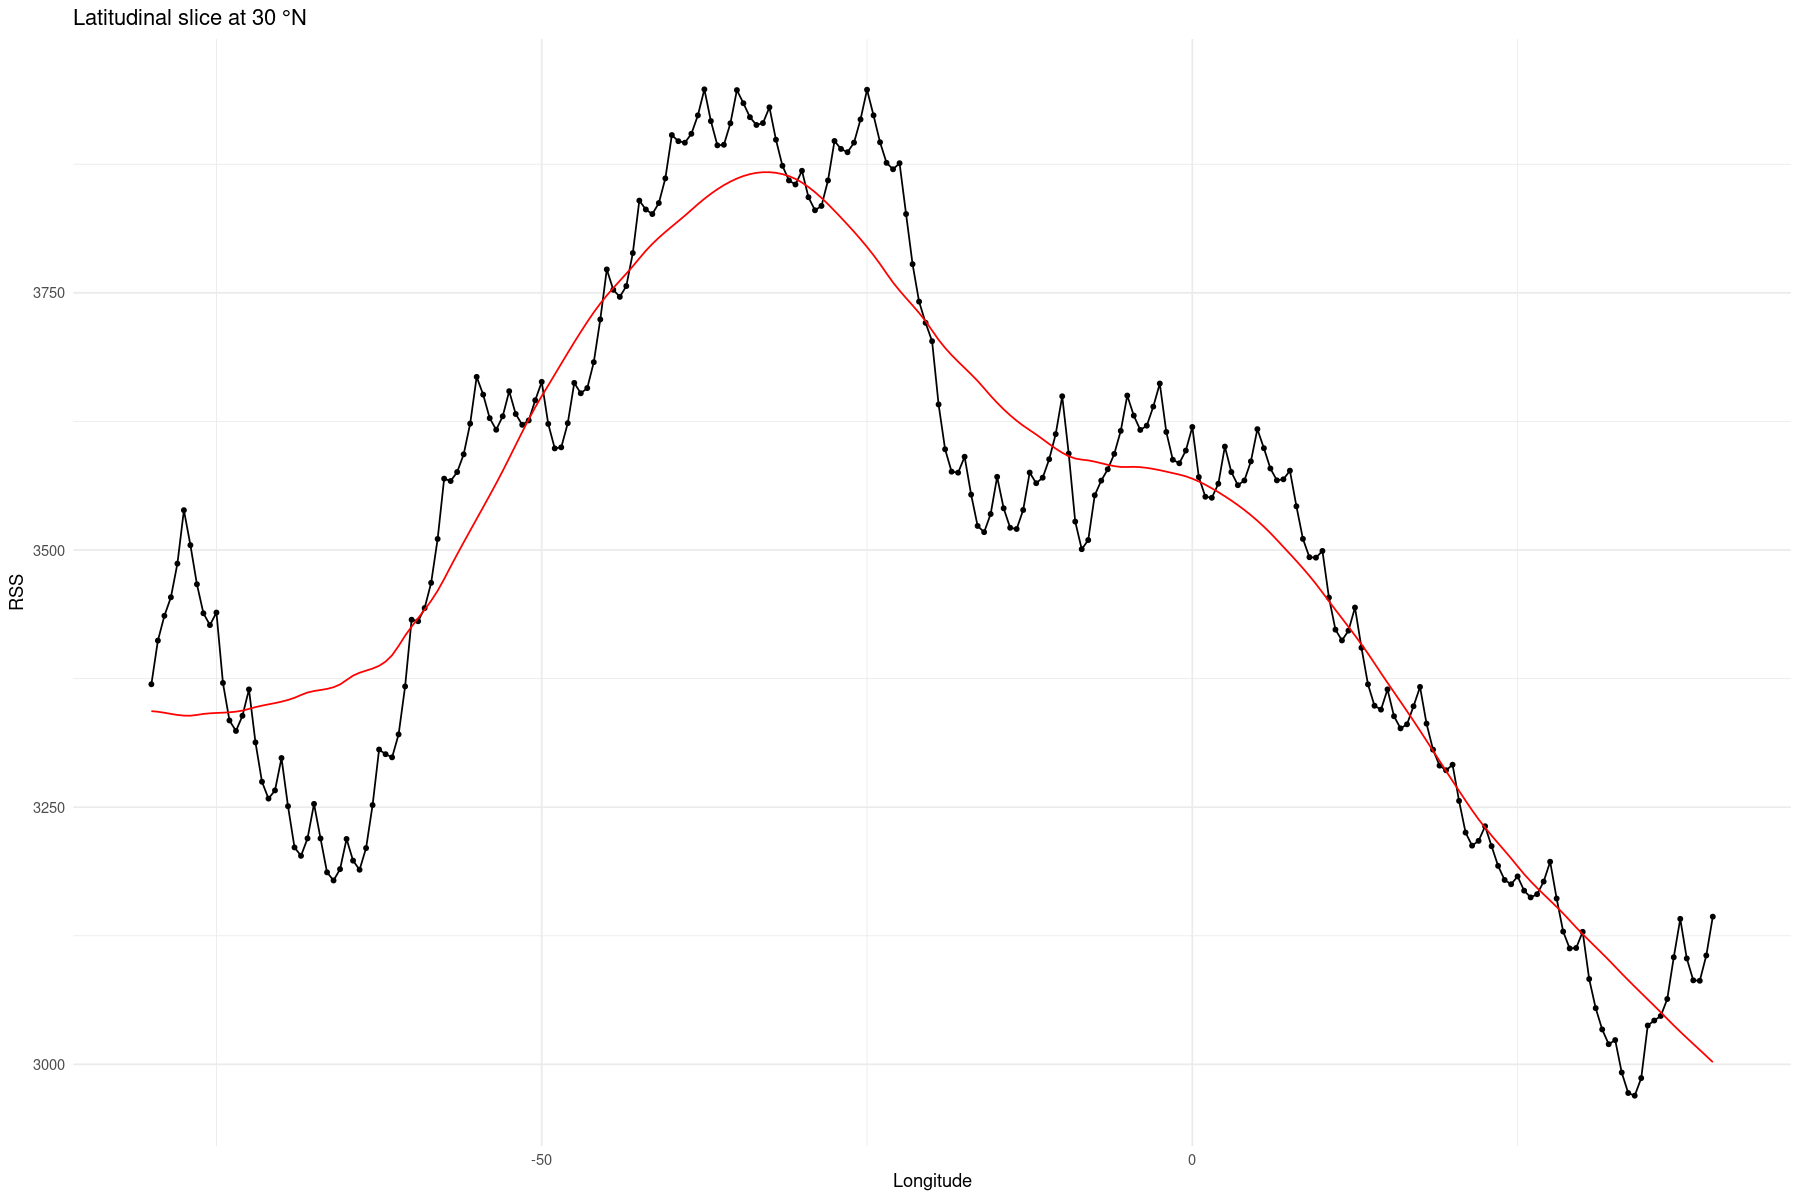

In [ ]:
res <- plot_trend_and_signal(
    x = rss_tbl$lon,
    y = rss_tbl$RSS,
    lat_focus = lat_focus,
    span = 0.3
)

rss_tbl$y_detrended <- res$y_detrended
rss_tbl$y_trend <- res$y_trend

res$plot


In [ ]:
grid_test <- grid_scale_spectral_test(
    y  = rss_tbl$y_detrended,
    dx = 0.5
)

grid_test


wavelength power_obs    power_null   ratio      p_value      p_adj       
1  0.5        1.990214e-07 4.678906e-07  0.4253587 6.535353e-01 6.535353e-01
2  1.0        1.990214e-07 4.678906e-07  0.4253587 6.535353e-01 6.535353e-01
3  1.5        3.708588e-07 6.249790e-07  0.5933940 5.524491e-01 6.535353e-01
4  2.0        9.415169e-07 9.335916e-07  1.0084891 3.647697e-01 6.535353e-01
5  2.5        5.586017e-05 1.341878e-06 41.6283625 8.337424e-19 8.337424e-18
6  3.0        1.528659e-06 1.838077e-06  0.8316618 4.353252e-01 6.535353e-01
7  3.5        1.633683e-06 2.451519e-06  0.6663963 5.135559e-01 6.535353e-01
8  4.0        1.380779e-06 3.066973e-06  0.4502092 6.374948e-01 6.535353e-01
9  4.5        3.978877e-06 3.703989e-06  1.0742141 3.415661e-01 6.535353e-01
10 5.0        4.322810e-06 4.569450e-06  0.9460240 3.882817e-01 6.535353e-01

### Check if problem persists with original model

In [44]:
compare_mod_orig <- readRDS(paste0(ENS_DATA_DIR, "checkermodsorig/lm30_-77.Rds"))
summary(compare_mod_orig)


Generalized least squares fit by REML
  Model: log_variance ~ segment + segment:year + segment:sin_doy + segment:cos_doy -      1 
  Data: z_df 
       AIC      BIC    logLik
  20651.69 20860.25 -10300.84

Coefficients:
                     Value Std.Error   t-value p-value
segment1         216.16309  4.644085  46.54590  0.0000
segment2          37.56332  4.475260   8.39355  0.0000
segment3          18.14704  1.195415  15.18054  0.0000
segment4          16.69704  1.414776  11.80190  0.0000
segment5          31.17347  3.630151   8.58738  0.0000
segment6           7.69631  1.923286   4.00165  0.0001
segment1:year     -0.10930  0.002389 -45.75025  0.0000
segment2:year     -0.01767  0.002292  -7.71043  0.0000
segment3:year     -0.00778  0.000607 -12.80590  0.0000
segment4:year     -0.00706  0.000712  -9.91653  0.0000
segment5:year     -0.01436  0.001812  -7.92257  0.0000
segment6:year     -0.00265  0.000954  -2.77698  0.0055
segment1:sin_doy   0.12555  0.008508  14.75744  0.0000
segment2:s

In [39]:
model_files <- list.files(paste0(ENS_DATA_DIR, "checkermodsorig/"),
    pattern = "^lm.*\\.Rds$", full.names = TRUE
)

# Function to extract lon, lat, RSS from a model file
extract_rss <- function(fpath) {
    fname <- basename(fpath)
    # Extract numbers from filename (assumes pattern lm<lat>_<lon>.Rds)
    nums <- str_extract_all(fname, "-?\\d+\\.?\\d*")[[1]]
    lat <- as.numeric(nums[1])
    lon <- as.numeric(nums[2])

    mod <- readRDS(fpath)
    res <- as.numeric(residuals(mod, type = "response"))
    RSS <- sum(res^2, na.rm = TRUE)

    tibble(lon = lon, lat = lat, RSS = RSS)
}

# Apply to all files and bind into a single tibble
rss_tbl <- map_dfr(model_files, extract_rss)


In [46]:
rss_tbl <- rss_tbl %>% filter(lon %% 1 < 0.001)


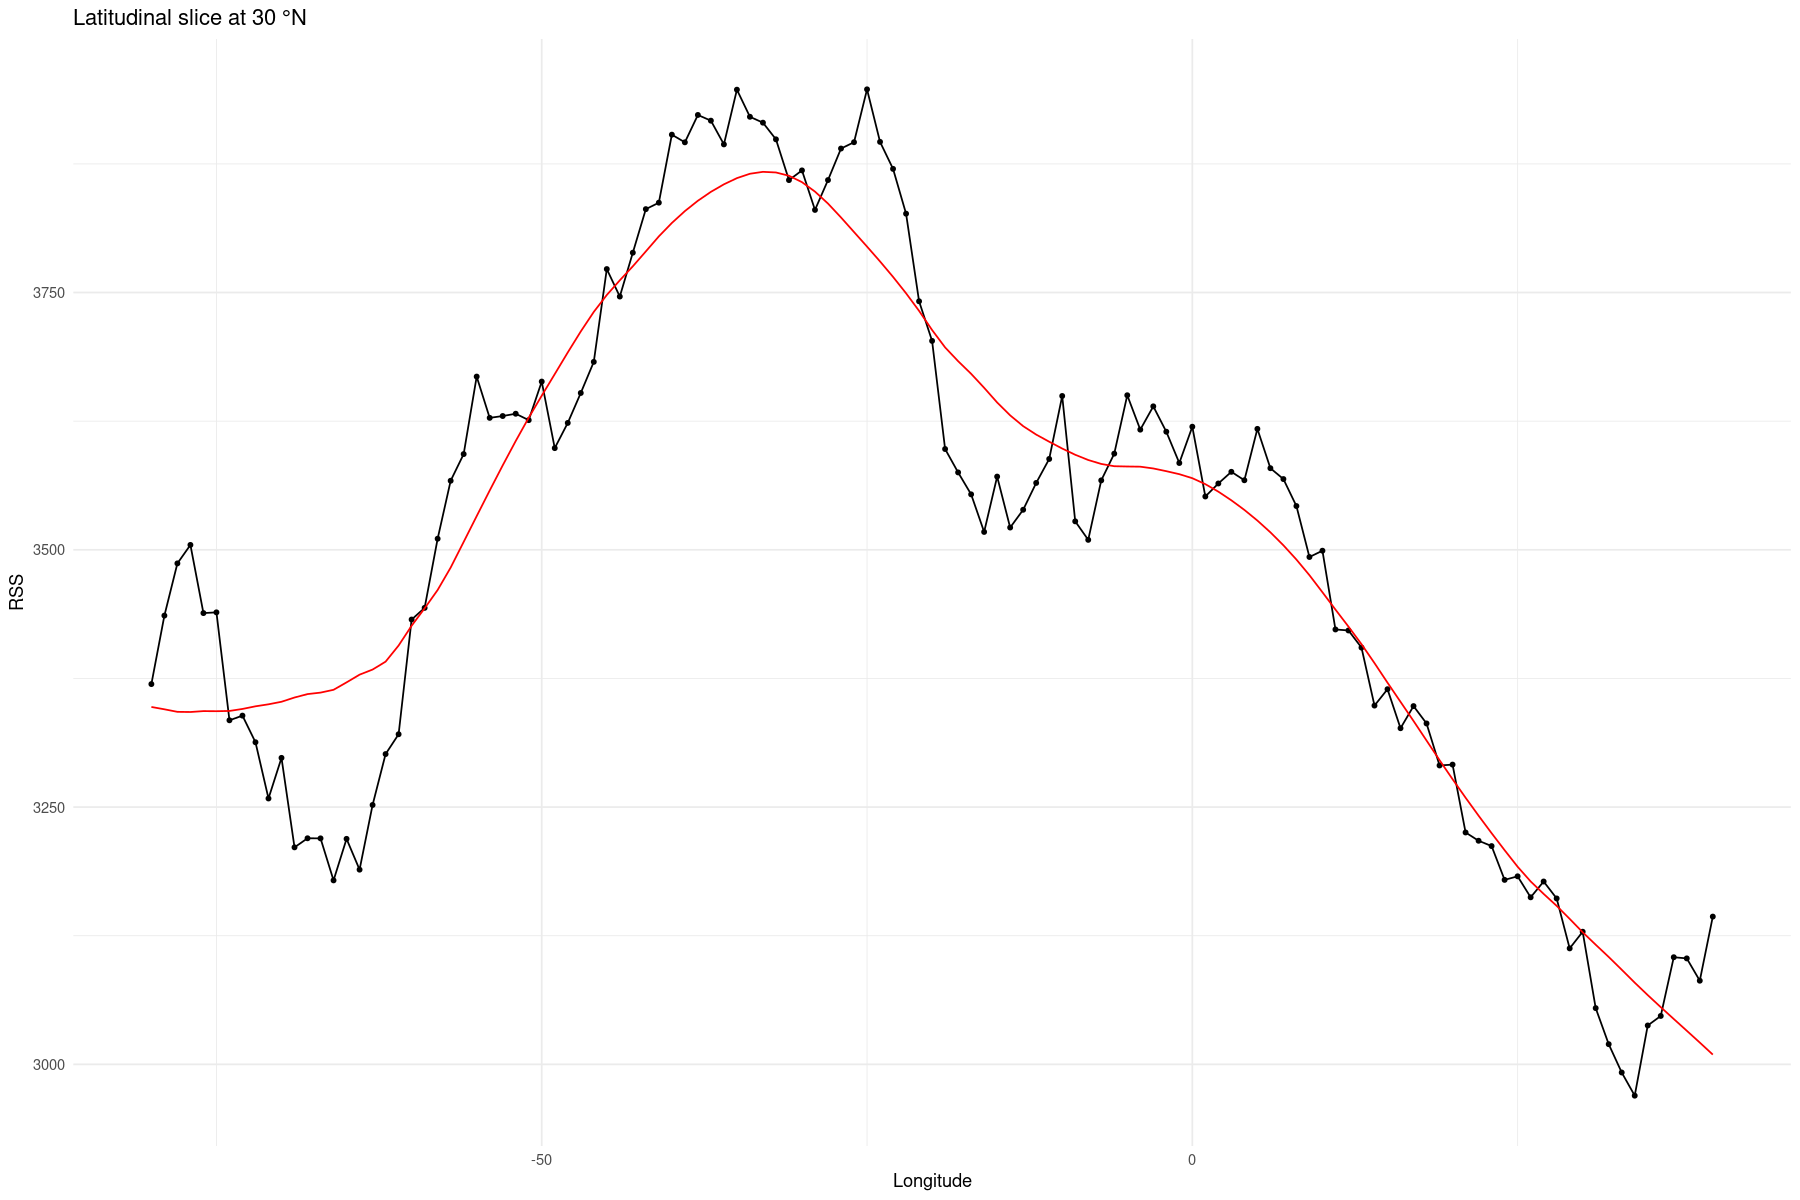

In [48]:
trend <- loess(rss_tbl$RSS ~ rss_tbl$lon, span = .3, degree = 1)
y_detrended <- rss_tbl$RSS - predict(trend)
rss_tbl$y_detrended <- y_detrended
rss_tbl$trend <- predict(trend)

# Plot a variable along longitude
ggplot(rss_tbl, aes(x = lon)) +
    geom_line(aes(y = RSS)) +
    geom_point(aes(y = RSS), size = 1) +
    labs(
        x = "Longitude",
        y = "RSS",
        title = paste("Latitudinal slice at", lat_focus, "°N")
    ) +
    geom_line(aes(y = trend), color = "red") +
    theme_minimal()


In [50]:
N <- length(y)
dx <- .5 # degrees

fft_y <- fft(y)
power <- Mod(fft_y)^2 / N
power <- power[1:floor(N / 2)]

freq <- (0:(length(power) - 1)) / (N * dx)
wavelength <- 1 / freq
phi_hat <- acf(y, lag.max = 1, plot = FALSE)$acf[2]
S_ar1 <- function(freq, phi, sigma2 = 1) {
    sigma2 / (1 + phi^2 - 2 * phi * cos(2 * pi * freq * dx))
}

spec_null <- S_ar1(freq, phi_hat)
spec_null <- spec_null * sum(power, na.rm = TRUE) / sum(spec_null, na.rm = TRUE)
grid_wavelengths <- dx * c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10) # 0.5°, 1°, 1.5°, 2°, 2.5°
idx <- sapply(grid_wavelengths, function(wl) {
    which.min(abs(wavelength - wl))
})
obs_power <- power[idx]
null_power <- spec_null[idx]

power_ratio <- obs_power / null_power
p_values <- exp(-power_ratio) # exact for χ²₂ / 2
grid_test <- data.frame(
    wavelength = grid_wavelengths,
    power_obs  = obs_power,
    power_null = null_power,
    ratio      = power_ratio,
    p_value    = p_values
)
grid_test$p_adj <- p.adjust(grid_test$p_value, method = "fdr")
grid_test


wavelength power_obs    power_null   ratio      p_value      p_adj       
1  0.5        1.990214e-07 4.678906e-07  0.4253587 6.535353e-01 6.535353e-01
2  1.0        1.990214e-07 4.678906e-07  0.4253587 6.535353e-01 6.535353e-01
3  1.5        3.708588e-07 6.249790e-07  0.5933940 5.524491e-01 6.535353e-01
4  2.0        9.415169e-07 9.335916e-07  1.0084891 3.647697e-01 6.535353e-01
5  2.5        5.586017e-05 1.341878e-06 41.6283625 8.337424e-19 8.337424e-18
6  3.0        1.528659e-06 1.838077e-06  0.8316618 4.353252e-01 6.535353e-01
7  3.5        1.633683e-06 2.451519e-06  0.6663963 5.135559e-01 6.535353e-01
8  4.0        1.380779e-06 3.066973e-06  0.4502092 6.374948e-01 6.535353e-01
9  4.5        3.978877e-06 3.703989e-06  1.0742141 3.415661e-01 6.535353e-01
10 5.0        4.322810e-06 4.569450e-06  0.9460240 3.882817e-01 6.535353e-01

### Check if with lm()

In [75]:
process_grid_point <- function(lat, lon, z, time, cps) {
    z_df <- data.frame(time = time, z = z)
    z_df$year <- as.integer(format(z_df$time, "%Y"))
    z_df$doy <- as.integer(format(z_df$time, "%j"))

    z_df$sin_doy <- sin(2 * pi * z_df$doy / 365)
    z_df$cos_doy <- cos(2 * pi * z_df$doy / 365)
    z_df$log_variance <- log(z_df$z)


    z_df$segment <- cut(as.Date(z_df$time),
        breaks = c(as.Date(c(
            z_df$time[1],
            cps,
            z_df$time[nrow(z_df)]
        ))),
        labels = 0:(length(cps)) + 1,
        include.lowest = TRUE,
        right = FALSE
    )
    z_df <- z_df %>%
        group_by(segment) %>%
        mutate(day_no = row_number()) %>%
        ungroup()

    lmod_seas <- lm(
        log_variance ~ segment +
            segment:year + segment:sin_doy + segment:cos_doy - 1,
        data = z_df
    )
    saveRDS(lmod_seas, file = paste0(
        ENS_DATA_DIR, "checkermods/lm", lat, "_", lon,
        ".Rds"
    ))
}


In [76]:
library(parallel)
# grid_points <- expand.grid(1:8, lat_idx)

n_cores <- 16

parallel::mclapply(
    seq_len(nrow(grid_points)),
    function(i) {
        lon_idx <- grid_points[i, 1]
        lat_idx <- grid_points[i, 2]

        file_path <- paste0(
            ENS_DATA_DIR, "checkermods/lm",
            lat_data[lat_idx], "_", lon_data[lon_idx],
            ".Rds"
        )

        process_grid_point(
            lat_data[lat_idx],
            lon_data[lon_idx],
            z_data[lon_idx, lat_idx, ],
            time,
            change_points
        )

        NULL
    },
    mc.cores = n_cores
)


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
NULL

[[103]]
NULL

[[104]]
NULL

[[105]]
NULL

[[106]]
NULL

[[107]]
NULL

[[108]]
NULL

[[109]]
NULL

[[110]]
NULL

[[111]]
NULL

[[112]]
NULL

[[113]]
NULL

[[114]]
NULL

[[115]]
NULL

[[116]]
NULL

[[117]]
NULL

[[118]]
NULL

[[119]]
NULL

[[120]]
NULL

[[121]]
NULL

[[122]]
NULL

[[123]]
NULL

[[124]]
NULL

[[125]]
NULL

[[126]]
NULL

[[127]]
NULL

[[128]]
NULL

[[129]]
NULL

[[130]]
NULL

[[131]]
NULL

[[132]]
NULL

[[133]]
NULL

[[134]]
NULL

[[135]]
NULL

[[136]]
NULL

[[137]]
NULL

[[138]]
NULL

[[139]]
NULL

[[140]]
NULL

[[141]]
NULL

[[142]]
NULL

[[143]]
NULL

[[144]]
NULL

[[145]]
NULL

[[146]]
NULL

[[147]]
NULL

[[148]]
NULL

[[149]]
NULL

[[150]]
NULL

[[151]]
NULL

[[152]]
NULL

[[153]]
NULL

[[154]]
NULL

[[155]]
NULL

[[156]]
NULL

[[157]]
NULL

[[158]]
NULL

[[159]]
NULL

[[160]]
NULL

[[161]]
NULL

[[162]]
NULL

[[163]]
NULL

[[164]]
NULL

[[165]]
NULL

[[166]]
NULL

[[167]]
NULL

[[168]]
NULL

[[169]]
NULL

[[170]]
NULL

[[171]]
NULL

[[172]]
NULL

[[173]]
NULL

[[174]]
NULL

[[175]]
NULL

[[176]]
NULL

[[177]]
NULL

[[178]]
NULL

[[179]]
NULL

[[180]]
NULL

[[181]]
NULL

[[182]]
NULL

[[183]]
NULL

[[184]]
NULL

[[185]]
NULL

[[186]]
NULL

[[187]]
NULL

[[188]]
NULL

[[189]]
NULL

[[190]]
NULL

[[191]]
NULL

[[192]]
NULL

[[193]]
NULL

[[194]]
NULL

[[195]]
NULL

[[196]]
NULL

[[197]]
NULL

[[198]]
NULL

[[199]]
NULL

[[200]]
NULL

[[201]]
NULL

[[202]]
NULL

[[203]]
NULL

[[204]]
NULL

[[205]]
NULL

[[206]]
NULL

[[207]]
NULL

[[208]]
NULL

[[209]]
NULL

[[210]]
NULL

[[211]]
NULL

[[212]]
NULL

[[213]]
NULL

[[214]]
NULL

[[215]]
NULL

[[216]]
NULL

[[217]]
NULL

[[218]]
NULL

[[219]]
NULL

[[220]]
NULL

[[221]]
NULL

[[222]]
NULL

[[223]]
NULL

[[224]]
NULL

[[225]]
NULL

[[226]]
NULL

[[227]]
NULL

[[228]]
NULL

[[229]]
NULL

[[230]]
NULL

[[231]]
NULL

[[232]]
NULL

[[233]]
NULL

[[234]]
NULL

[[235]]
NULL

[[236]]
NULL

[[237]]
NULL

[[238]]
NULL

[[239]]
NULL

[[240]]
NULL

[[241]]
NULL

In [77]:
model_files <- list.files(paste0(ENS_DATA_DIR, "checkermods/"),
    pattern = "^lm30_.*\\.Rds$", full.names = TRUE
)

ss_tbl_30 <- map_dfr(model_files, extract_ss)


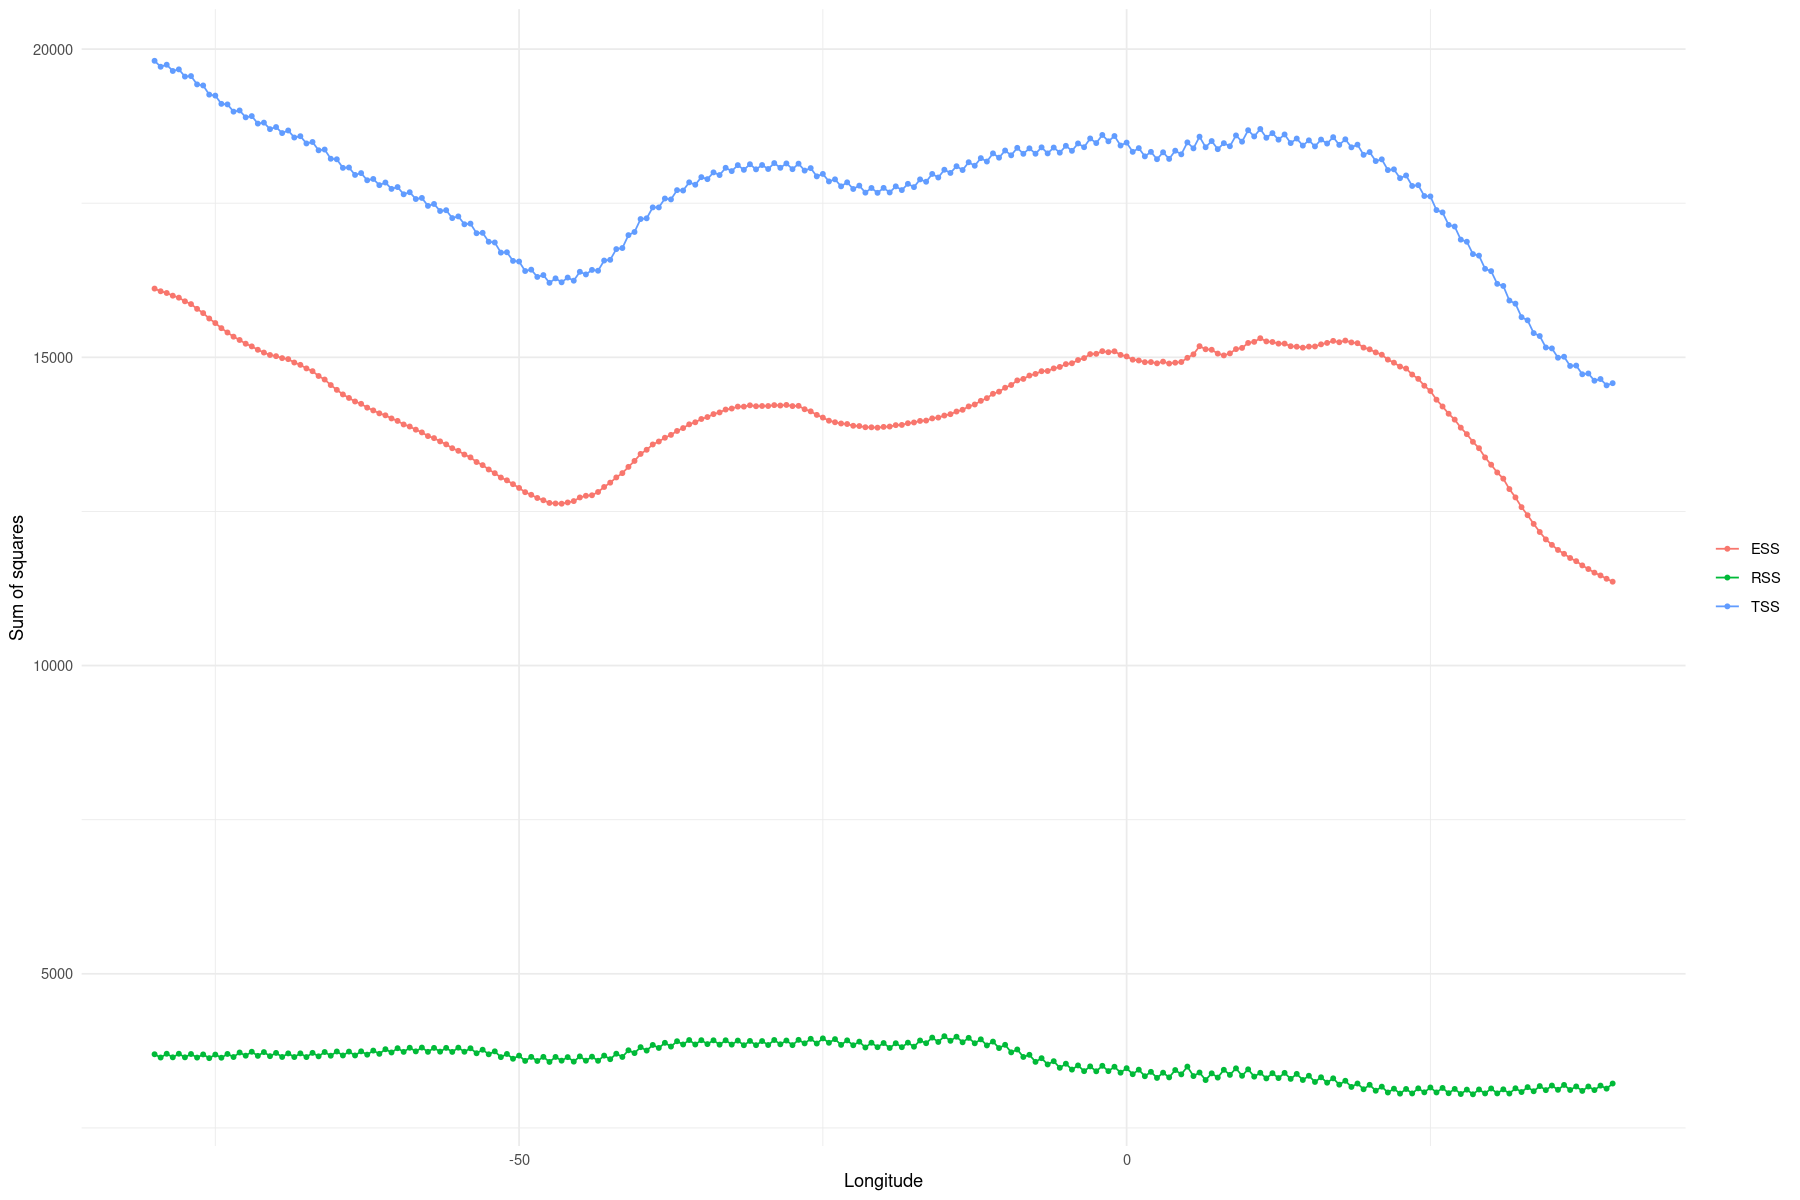

In [93]:
df_long <- ss_tbl %>%
    pivot_longer(c(RSS, TSS, ESS),
        names_to = "quantity",
        values_to = "value"
    )

ggplot(df_long, aes(x = lon, y = value, color = quantity)) +
    geom_line() +
    geom_point(size = 1) +
    labs(
        x = "Longitude",
        y = "Sum of squares",
        color = NULL
    ) +
    theme_minimal()


In [94]:
lon_idx <- match(ss_tbl$lon, lon_data)
lat_idx <- match(ss_tbl$lat, lat_data)

# sd over time for each (lon, lat)
sd_time <- mapply(
    function(i, j) sd(log(z_data[i, j, ]), na.rm = TRUE),
    lon_idx, lat_idx
)

ss_tbl <- ss_tbl %>%
    mutate(sd_data = sd_time)


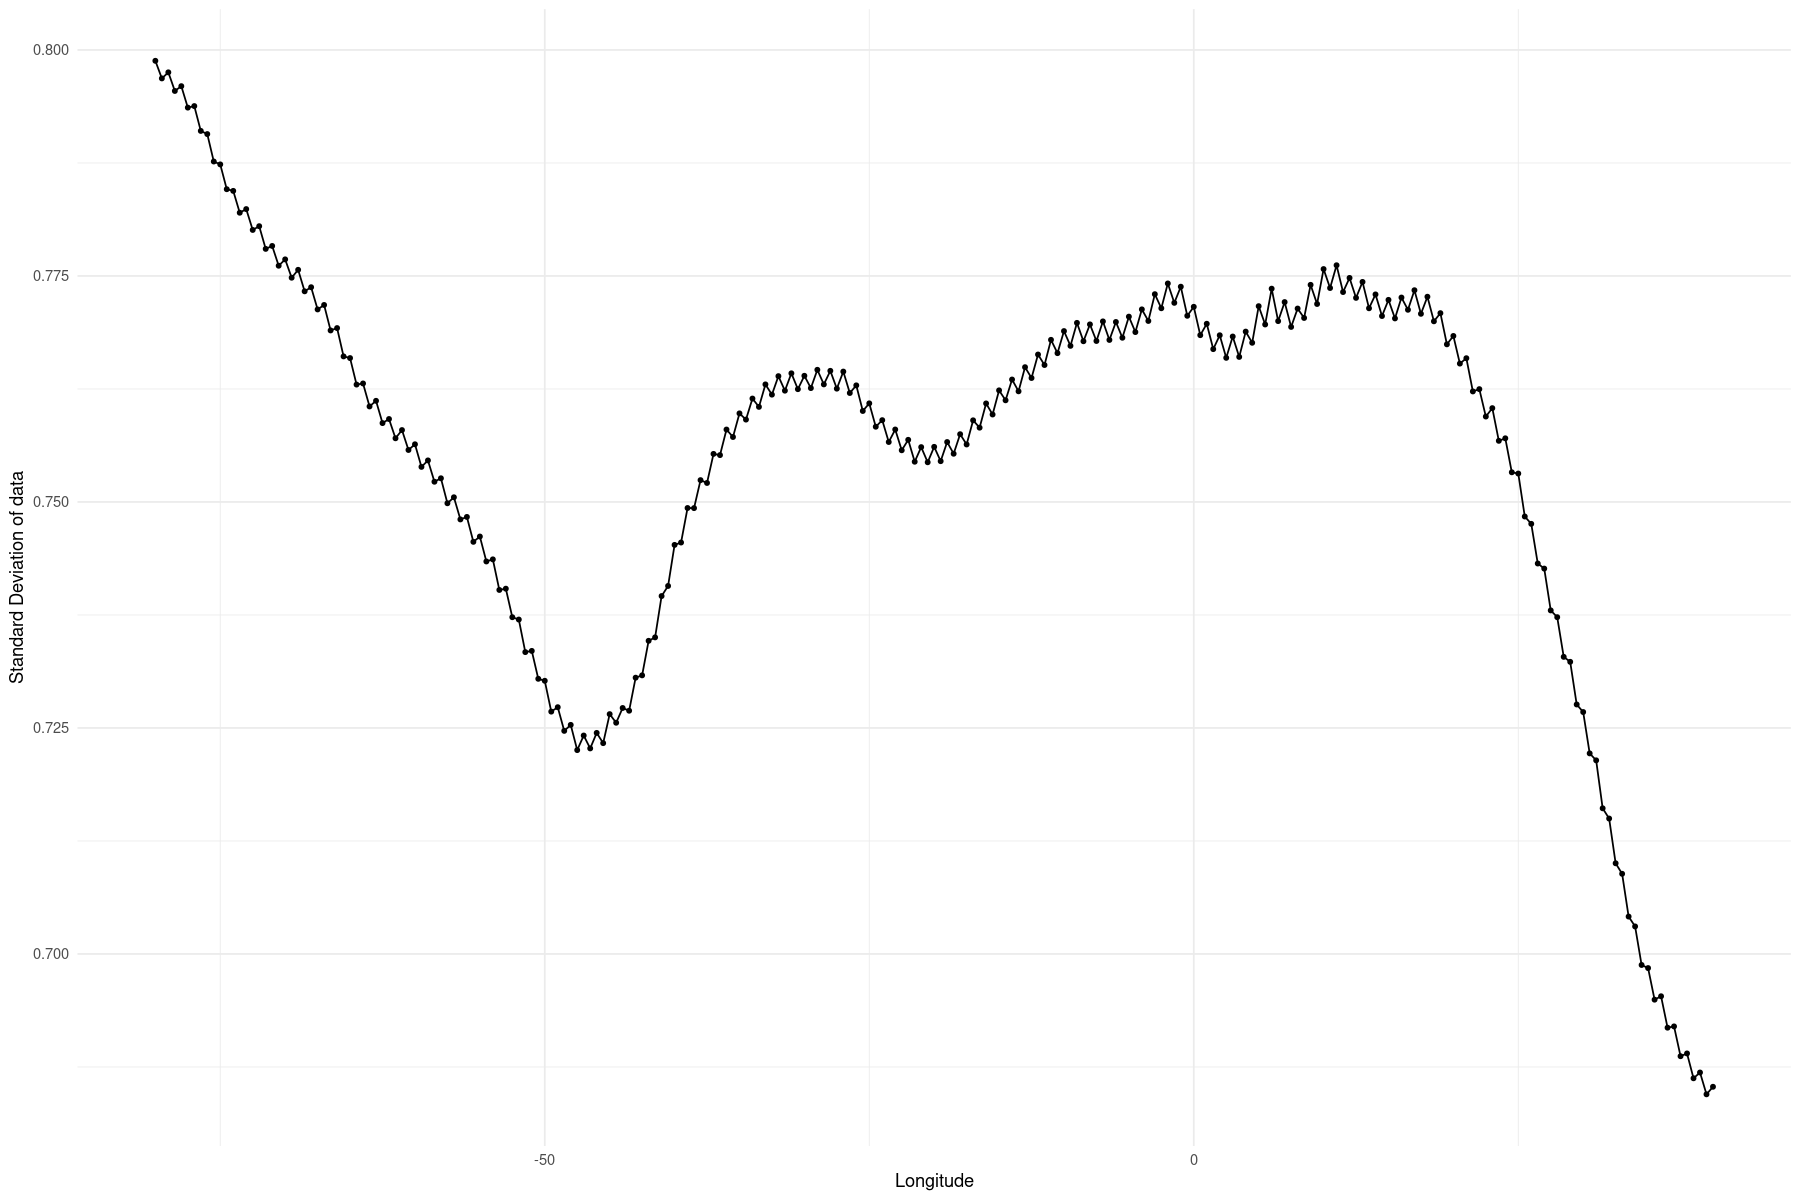

In [95]:
ggplot(ss_tbl, aes(x = lon, y = sd_data)) +
    geom_line() +
    geom_point(size = 1) +
    labs(
        x = "Longitude",
        y = "Standard Deviation of data"
    ) +
    theme_minimal()


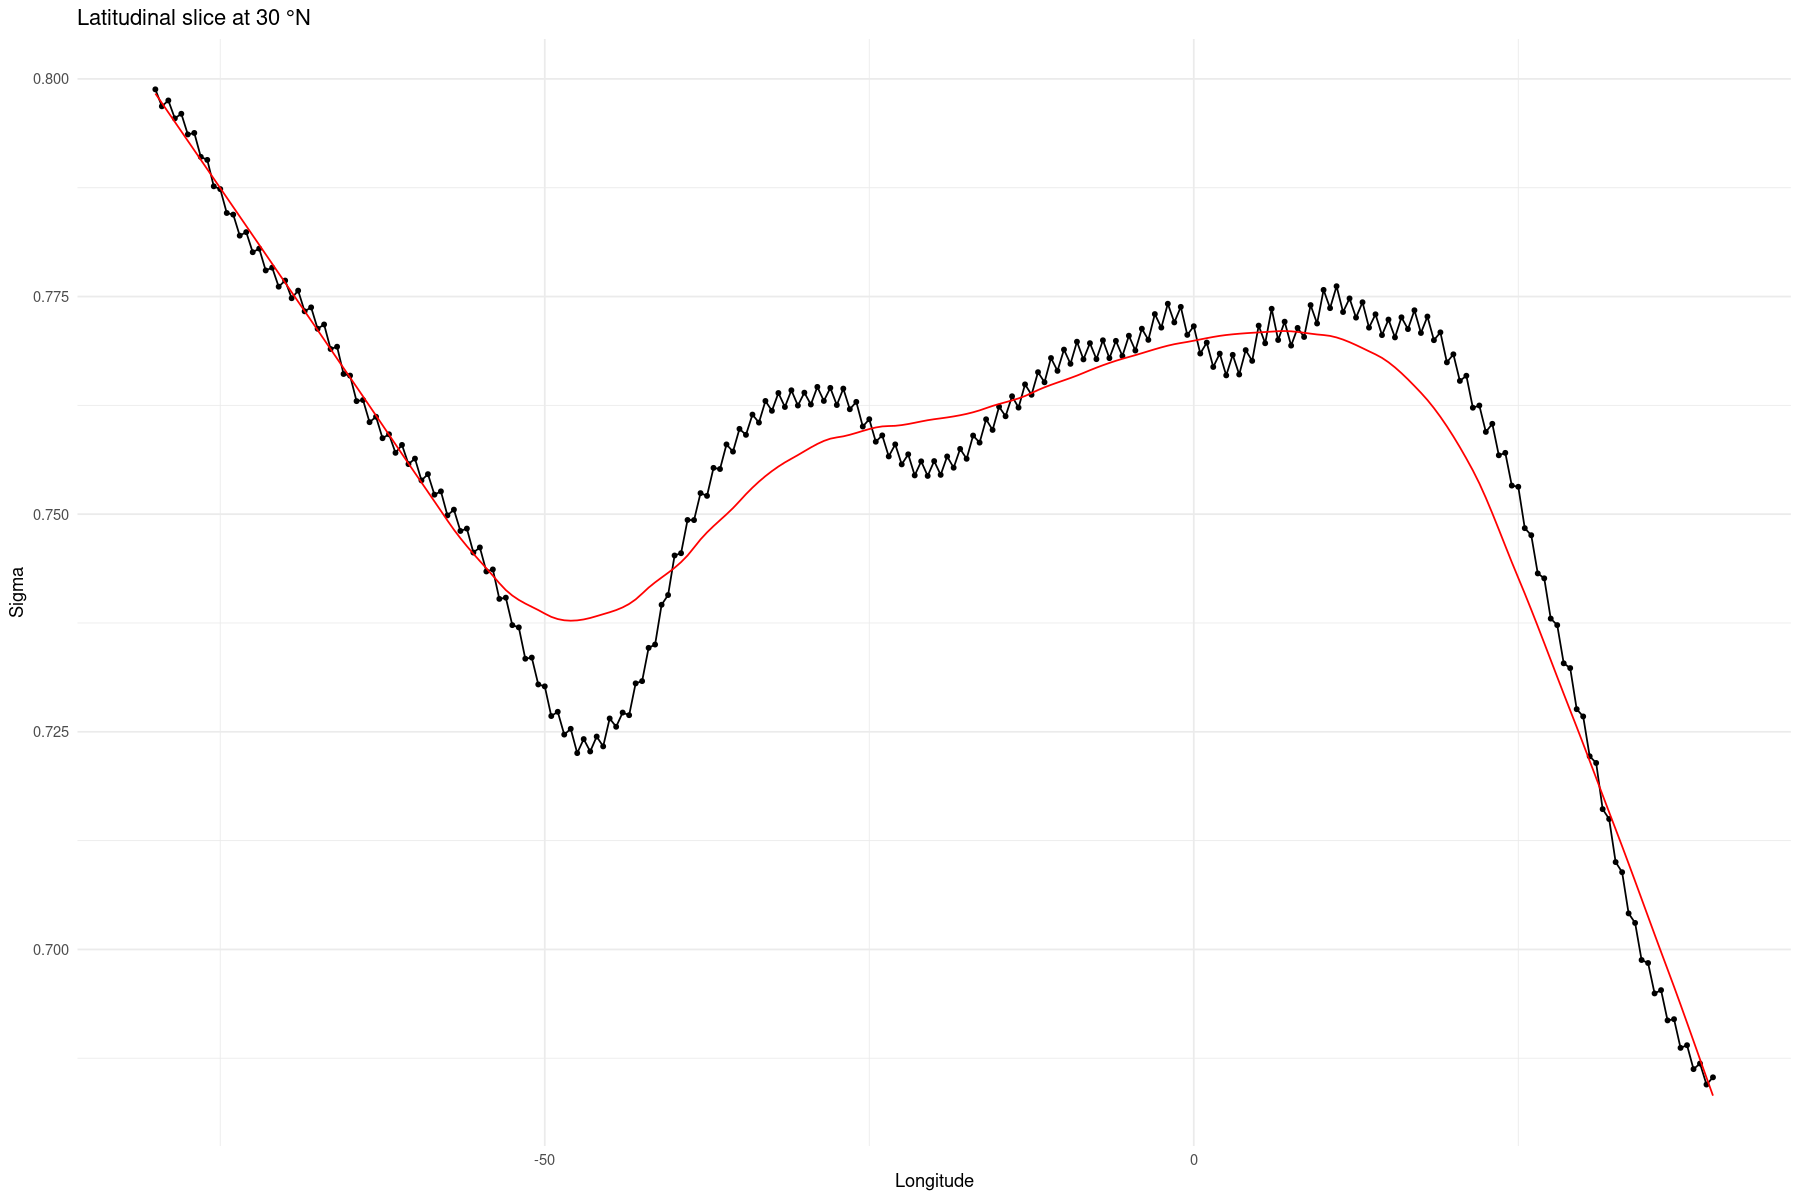

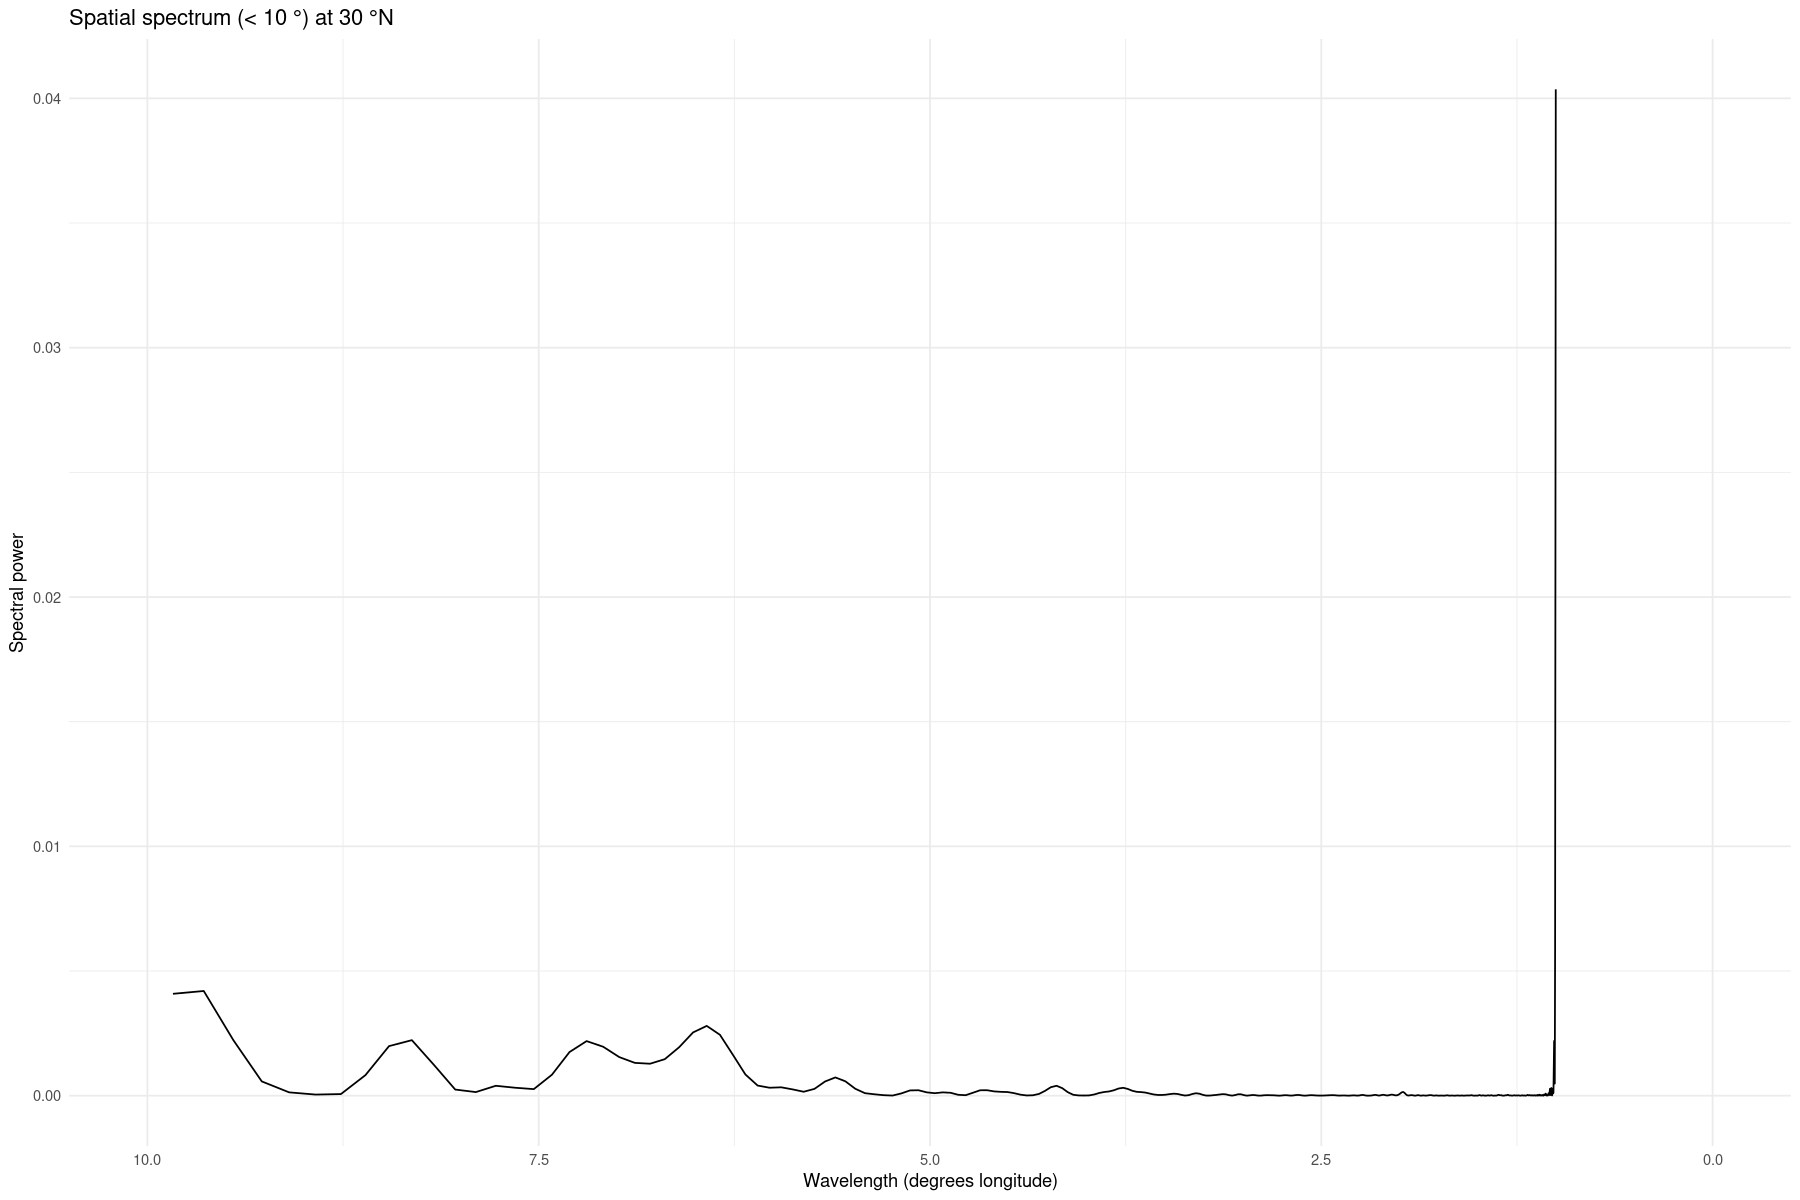

In [97]:
res <- plot_trend_and_signal(
    x = ss_tbl$lon,
    y = ss_tbl$sd_data,
    lat_focus = lat_focus,
    span = 0.3
)

ss_tbl$y_detrended <- res$y_detrended
ss_tbl$y_trend <- res$y_trend

res$plot

ss_tbl <- ss_tbl %>% arrange(lon)

spec_res <- plot_lon_spectrum(
    lon = ss_tbl$lon,
    y_detrended = ss_tbl$y_detrended,
    lat_focus = lat_focus,
    max_wavelength = 10,
    pad_factor = 4
)

spec_res$plot


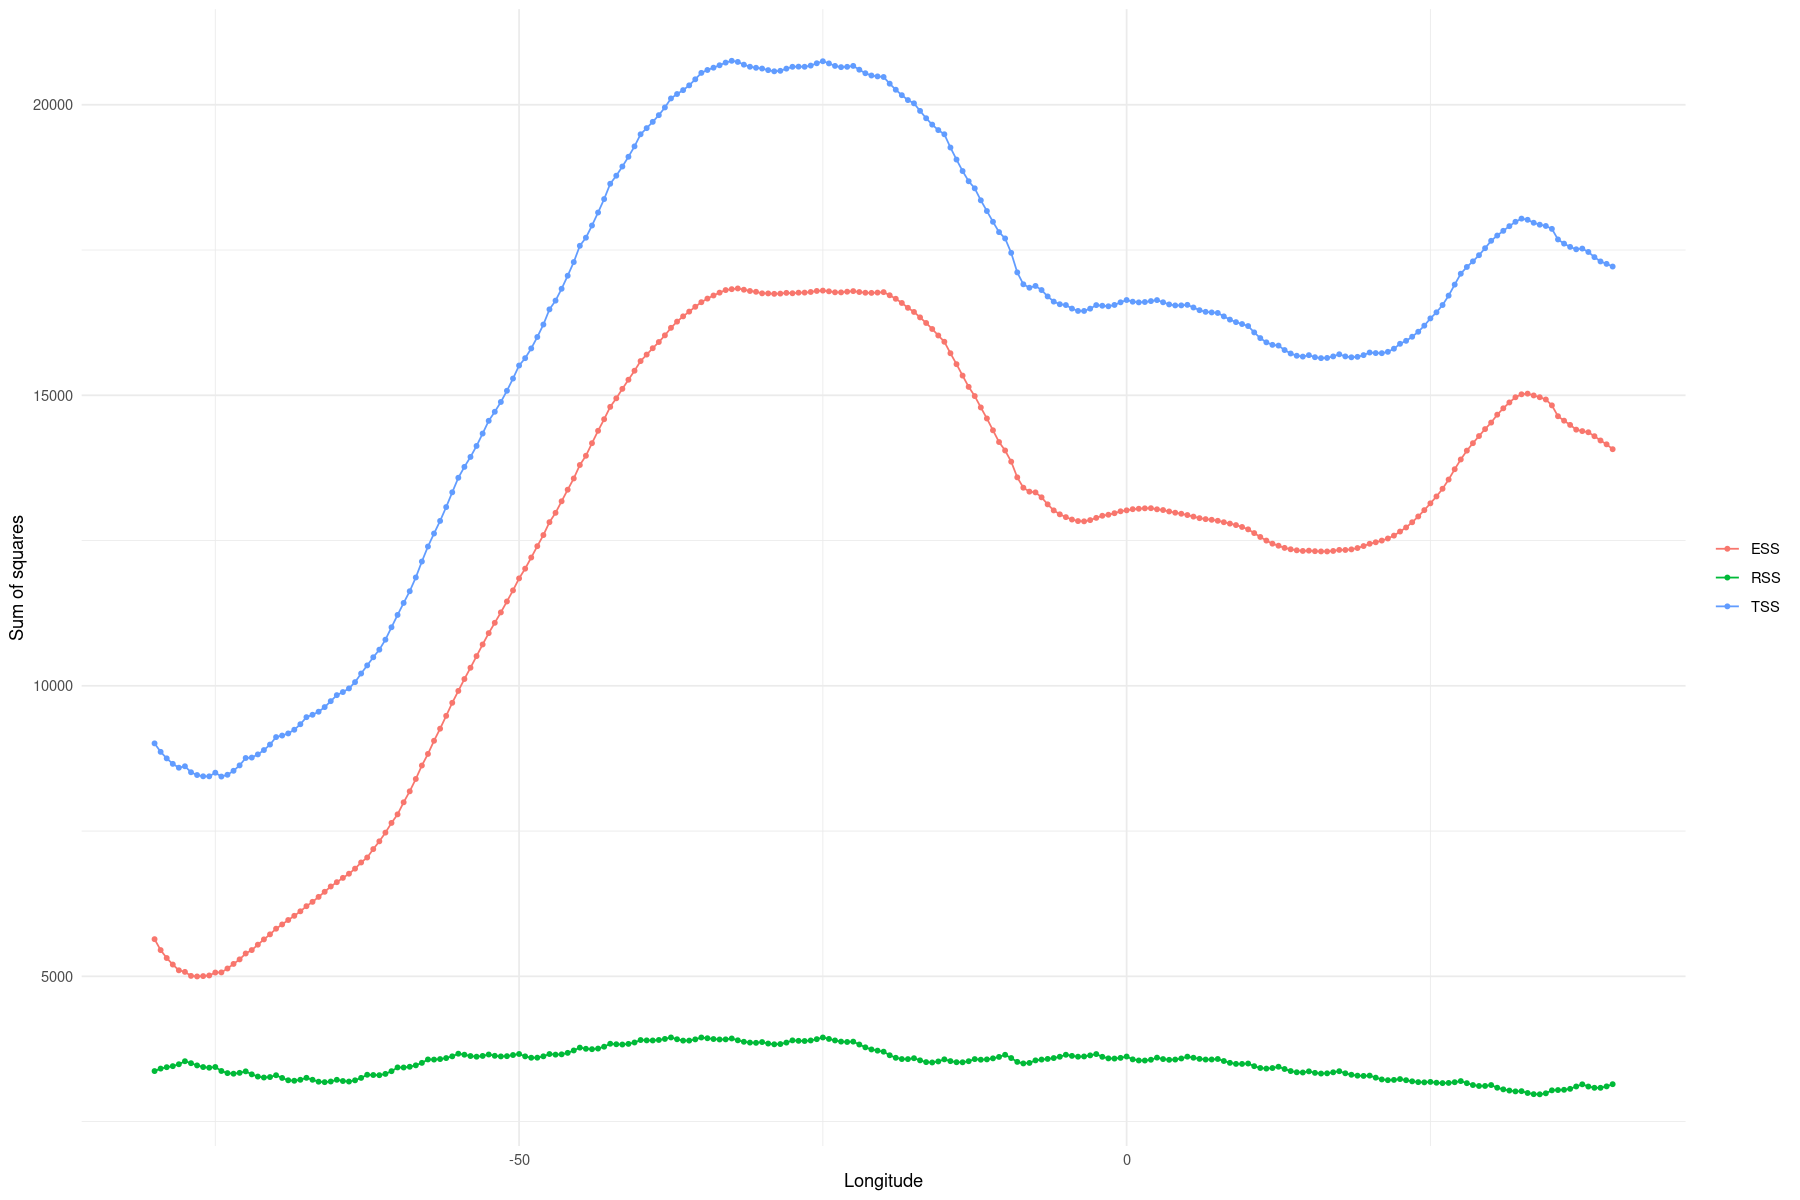

In [78]:
df_long <- ss_tbl_30 %>%
    pivot_longer(c(RSS, TSS, ESS),
        names_to = "quantity",
        values_to = "value"
    )

ggplot(df_long, aes(x = lon, y = value, color = quantity)) +
    geom_line() +
    geom_point(size = 1) +
    labs(
        x = "Longitude",
        y = "Sum of squares",
        color = NULL
    ) +
    theme_minimal()


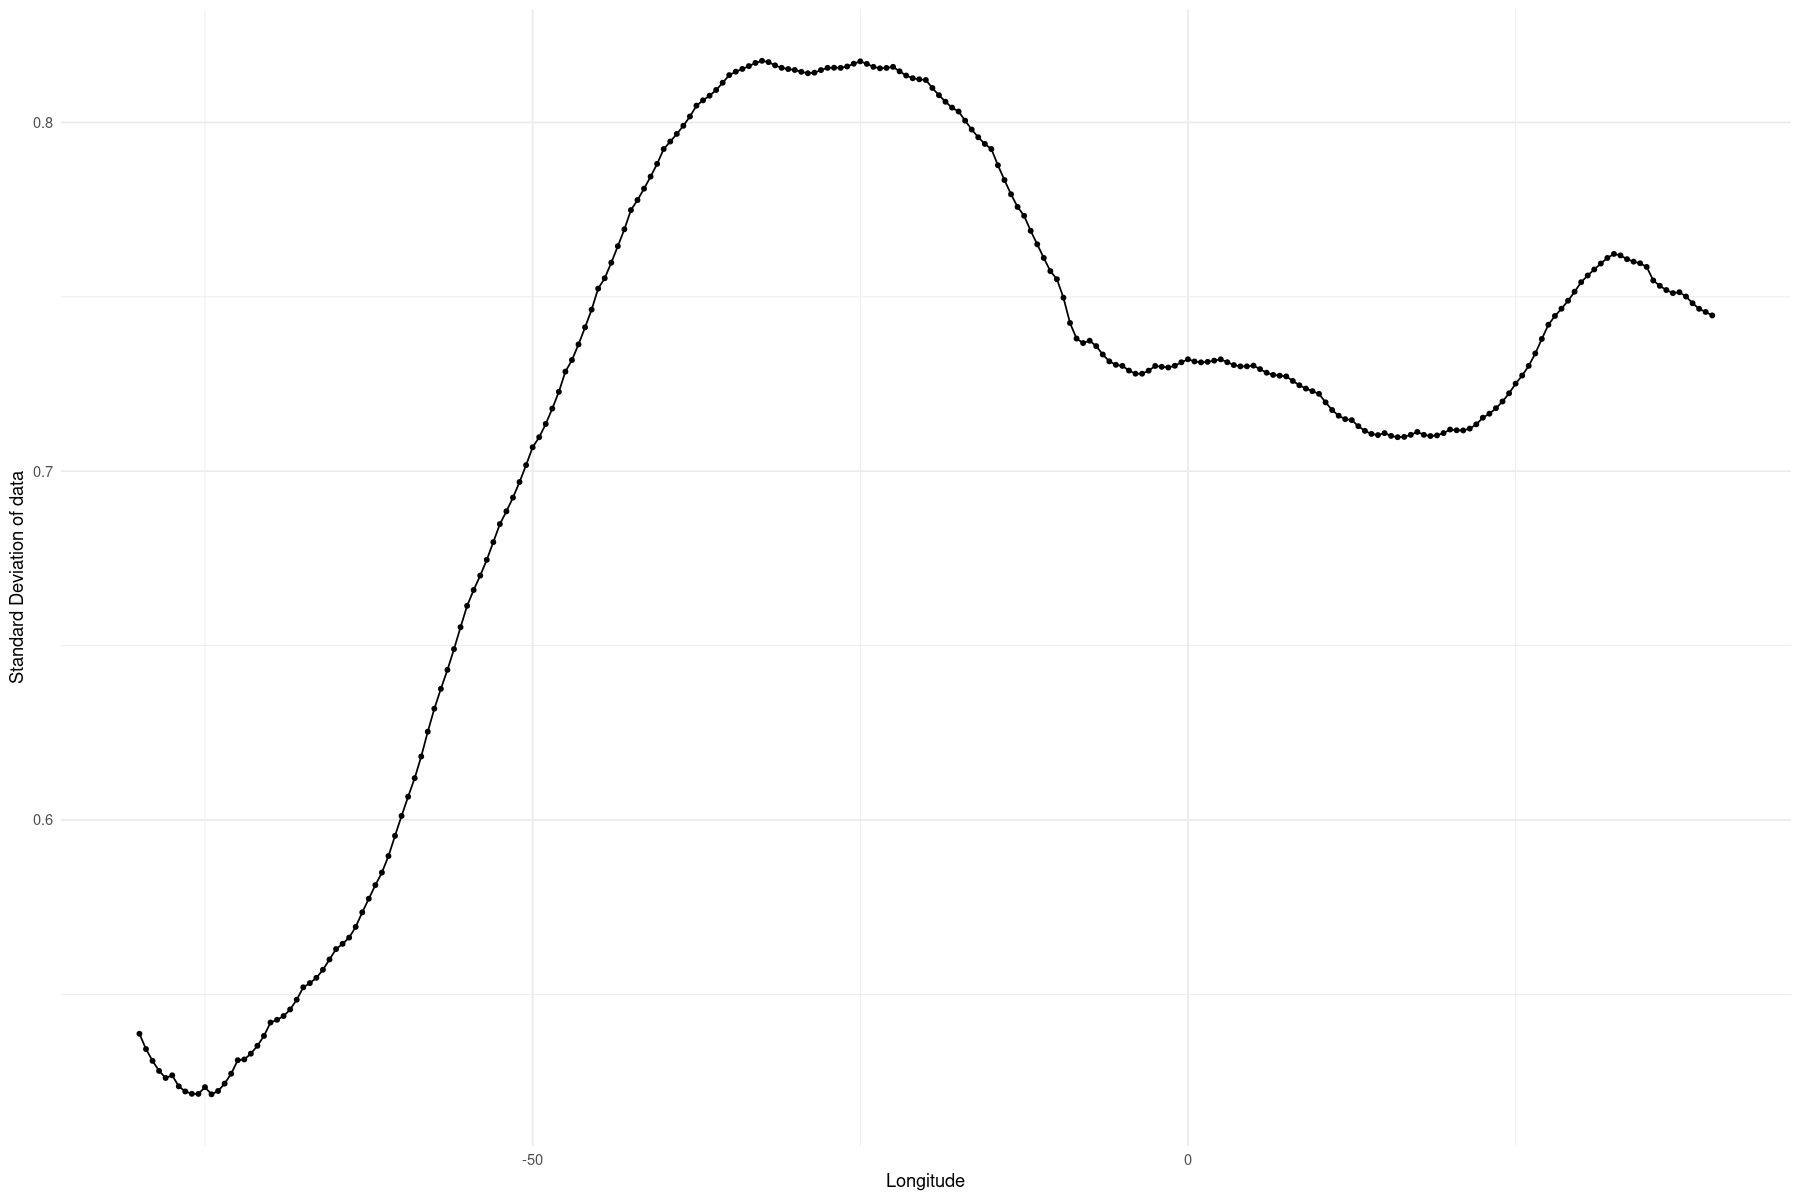

In [79]:
lon_idx <- match(ss_tbl_30$lon, lon_data)
lat_idx <- match(ss_tbl_30$lat, lat_data)

# sd over time for each (lon, lat)
sd_time <- mapply(
    function(i, j) sd(log(z_data[i, j, ]), na.rm = TRUE),
    lon_idx, lat_idx
)

ss_tbl <- ss_tbl %>%
    mutate(sd_data = sd_time)

ggplot(ss_tbl, aes(x = lon, y = sd_data)) +
    geom_line() +
    geom_point(size = 1) +
    labs(
        x = "Longitude",
        y = "Standard Deviation of data"
    ) +
    theme_minimal()


### Look at wiggles systematically

In [102]:
library(dplyr)
library(tidyr)

compute_sdlog_lon_spectra <- function(z_data, lon_data, lat_data,
                                      max_wavelength = 5,
                                      pad_factor = 4,
                                      wgrid = seq(0.05, 5, by = 0.02),
                                      span = 0.30) {
    # z_data assumed [lon, lat, time]
    nlon <- length(lon_data)
    nlat <- length(lat_data)

    # output matrix: rows = latitudes, cols = wavelengths (deg)
    spec_mat <- matrix(NA_real_, nrow = nlat, ncol = length(wgrid))

    # small epsilon for log stability (fallback if no positives)
    pos_vals <- z_data[z_data > 0]
    eps <- if (length(pos_vals) > 0) median(pos_vals, na.rm = TRUE) * 1e-8 else 1e-12

    # iterate latitudes
    for (j in seq_len(nlat)) {
        # 1) compute sd over time of log(z) at each longitude
        slice <- z_data[, j, , drop = FALSE] # lon x time
        slice <- matrix(slice, nrow = nlon)
        sd_log <- apply(log(pmax(slice, eps)), 1, sd, na.rm = TRUE) # length nlon

        # 2) ensure lon ordering and build df
        df_lon <- tibble(lon = lon_data, sd = sd_log) %>% arrange(lon)
        lon_sorted <- df_lon$lon
        y <- df_lon$sd
        n <- length(y)
        if (n < 4 || all(is.na(y))) next # skip lat if too short or all NA

        dx <- mean(diff(lon_sorted)) # spacing in degrees

        # 3) detrend with LOESS (remove large-scale / low-wavenumber)
        # handle cases where loess fails by fallback to zero trend
        trend_ok <- TRUE
        trend_vals <- tryCatch(
            {
                lo <- loess(y ~ lon_sorted, span = span, degree = 1)
                predict(lo, newdata = lon_sorted)
            },
            error = function(e) {
                trend_ok <<- FALSE
                rep(0, n)
            }
        )
        y_detr <- y - trend_vals

        # 4) FFT on detrended (zero-pad)
        n_fft <- max(4, pad_factor * n) # ensure >=4
        y_pad <- c(y_detr, rep(0, n_fft - n))

        fft_vals <- fft(y_pad)
        power <- Mod(fft_vals)^2

        # 5) determine positive-frequency bins excluding zero-frequency
        pos <- 2:floor(n_fft / 2) # skip index 1 (zero freq)
        if (length(pos) < 1) next

        freq_pos <- pos / (n_fft * dx) # cycles per degree
        wavelength_pos <- 1 / freq_pos # degrees

        # 6) keep wavelengths within requested window and finite
        valid <- which(is.finite(wavelength_pos) & wavelength_pos <= max_wavelength)
        if (length(valid) == 0) next

        x_vals <- wavelength_pos[valid]
        y_vals <- power[pos][valid]

        # approx requires x increasing: sort
        ord <- order(x_vals)
        x_sorted <- x_vals[ord]
        y_sorted <- y_vals[ord]

        # 7) interpolate (handle single-point case)
        if (length(x_sorted) == 1) {
            interp <- rep(y_sorted, length(wgrid))
        } else {
            interp <- approx(x = x_sorted, y = y_sorted, xout = wgrid, rule = 2)$y
        }

        spec_mat[j, ] <- interp
    }

    # tidy output for plotting or further analysis
    colnames(spec_mat) <- paste0("w", seq_along(wgrid))
    spec_df <- as.data.frame(spec_mat) %>%
        mutate(latitude = lat_data) %>%
        pivot_longer(cols = starts_with("w"), names_to = "w_index", values_to = "power") %>%
        mutate(
            w_idx = as.integer(sub("^w", "", w_index)),
            wavelength = wgrid[w_idx],
            log10power = log10(power + 1e-16),
            power = power
        )

    return(list(
        spec_mat = spec_mat, # matrix (nlat x nw)
        wgrid = wgrid, # wavelength vector (deg)
        lat = lat_data,
        spec_df = spec_df # tidy dataframe: latitude, wavelength, power, log10power
    ))
}


In [103]:
res <- compute_sdlog_lon_spectra(z_data, lon_data, lat_data,
    max_wavelength = 5,
    pad_factor = 4,
    wgrid = seq(0.05, 5, by = 0.02),
    span = 0.3
)

# spec matrix:
spec_mat <- res$spec_mat # rows: lat, cols: wavelengths

# tidy dataframe for ggplot:
spec_df <- res$spec_df


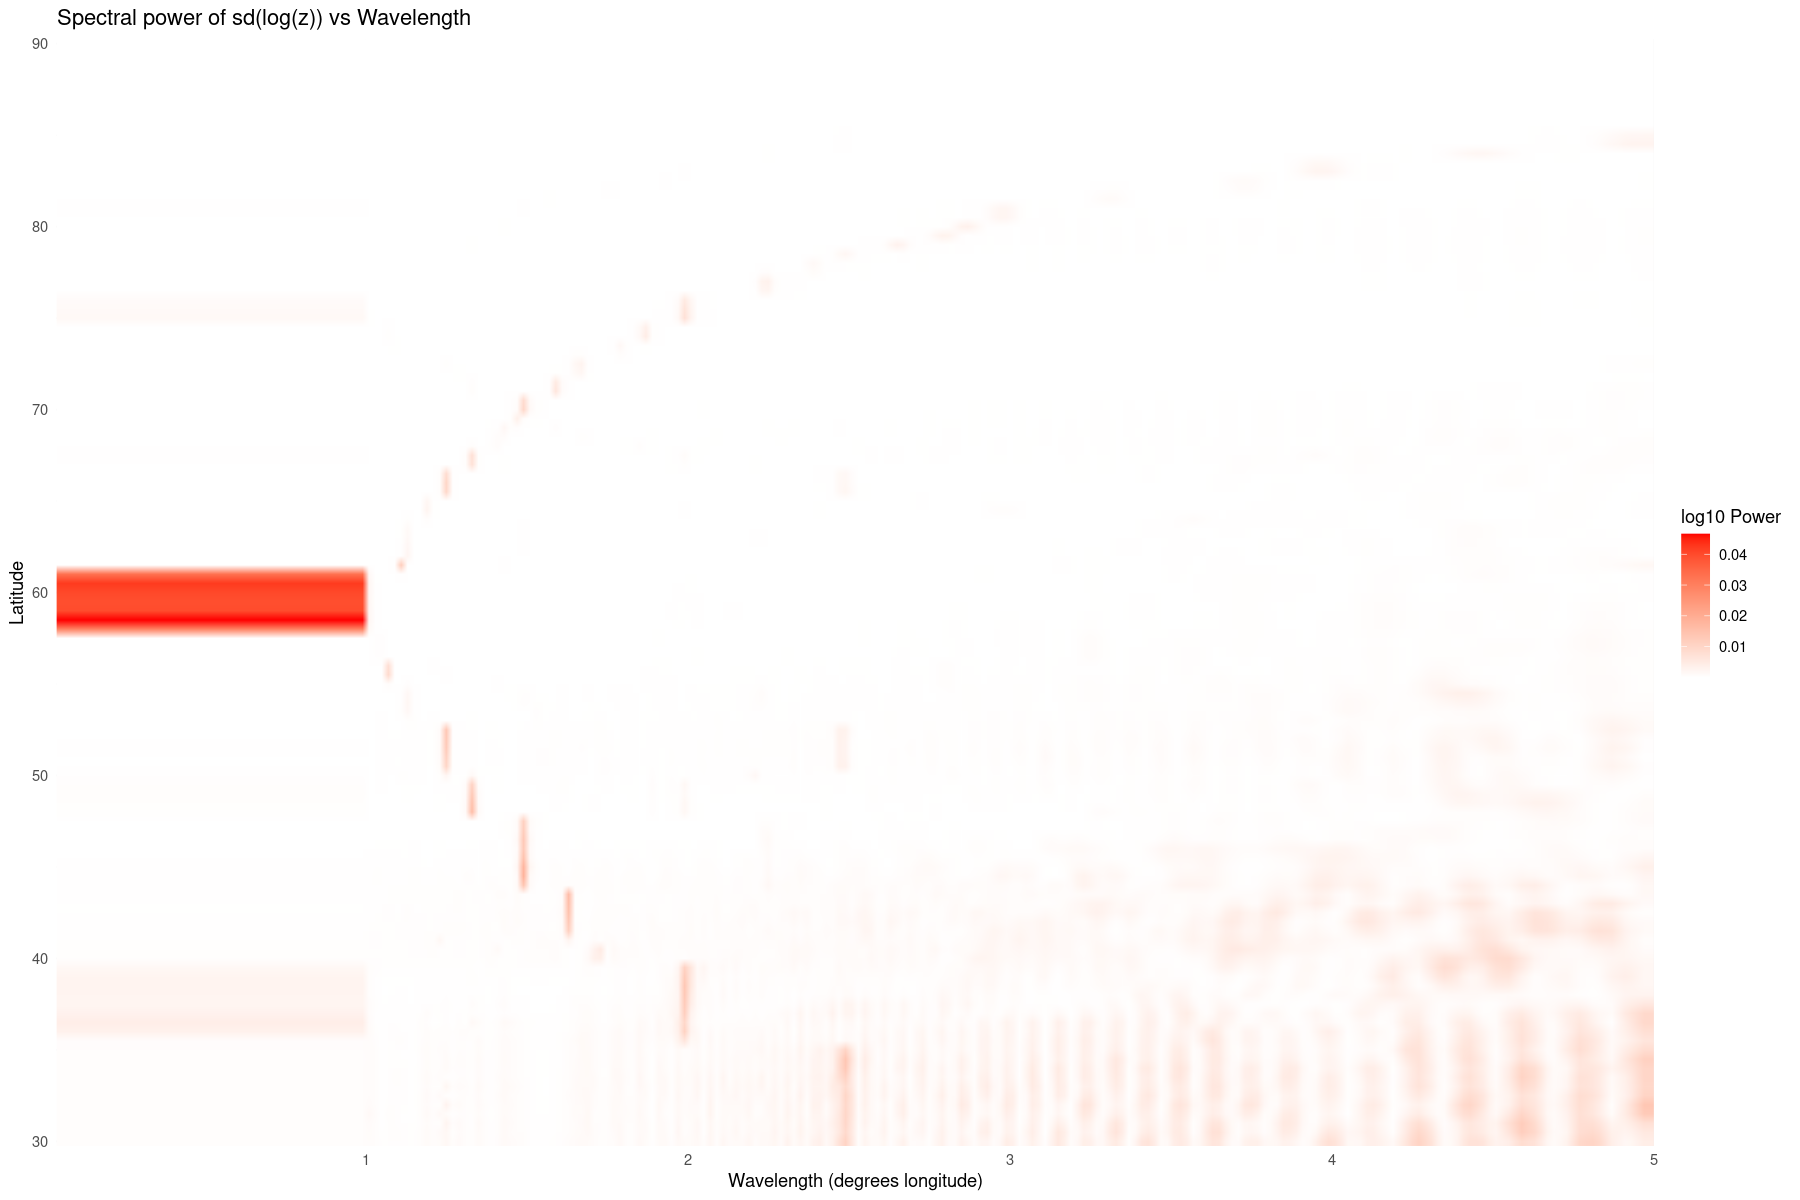

In [ ]:
library(ggplot2)

# spec_df from compute_sdlog_lon_spectra
# columns: latitude, wavelength, power, log10power

ggplot(spec_df, aes(x = wavelength, y = latitude, fill = power)) +
    geom_raster(interpolate = TRUE) + # heatmap
    scale_fill_gradient(
        low = "white", high = "red", na.value = "grey80"
    ) +
    labs(
        x = "Wavelength (degrees longitude)",
        y = "Latitude",
        fill = "Power",
        title = "Spectral power of sd(log(z)) vs Wavelength"
    ) +
    theme_minimal() +
    coord_cartesian(expand = FALSE)


# Compare to spread from individual members

In [9]:
library(ncdf4)
library(dplyr)
library(tibble)

# open files
nc1 <- nc_open(paste0(ENS_DATA_DIR, "geopotential.nc"))
nc2 <- nc_open(paste0(ENS_DATA_DIR, "geopotential_from_members.nc"))

# read coordinates
lat <- ncvar_get(nc1, "latitude")
lon <- ncvar_get(nc1, "longitude")

# read variable
z1 <- ncvar_get(nc1, "z")
z2 <- ncvar_get(nc2, "z")

nc_close(nc1)
nc_close(nc2)

# assume array order: [lon, lat, time]
# reorder to [time, lat, lon]
z1 <- aperm(z1, c(3, 2, 1))
z2 <- aperm(z2, c(3, 2, 1))

# sd over time of log(z)
sd1 <- apply(log(z1), c(2, 3), sd)
sd2 <- apply(log(z2), c(2, 3), sd)

# build tibble
out <- expand.grid(
    lat = lat,
    lon = lon
) %>%
    as_tibble() %>%
    mutate(
        sd_log_direct = as.vector(sd1),
        sd_log_from_members = as.vector(sd2)
    )


lat  lon sd_log_direct sd_log_from_members
1     90.0 -80 1.0722605     1.0811668          
2     89.5 -80 1.0747748     1.0759888          
3     89.0 -80 1.0724022     1.0734925          
4     88.5 -80 1.0693413     1.0704703          
5     88.0 -80 1.0645944     1.0663010          
6     87.5 -80 1.0590556     1.0610294          
7     87.0 -80 1.0522770     1.0544841          
8     86.5 -80 1.0441009     1.0465434          
9     86.0 -80 1.0344603     1.0370032          
10    85.5 -80 1.0241123     1.0263291          
11    85.0 -80 1.0137480     1.0152322          
12    84.5 -80 1.0026952     1.0037754          
13    84.0 -80 0.9905796     0.9923767          
14    83.5 -80 0.9792106     0.9810093          
15    83.0 -80 0.9684953     0.9704599          
16    82.5 -80 0.9577521     0.9607871          
17    82.0 -80 0.9481284     0.9511287          
18    81.5 -80 0.9398062     0.9423675          
19    81.0 -80 0.9324289     0.9354735          
20    80.5 -80 0.9264104     0.9291384          
21    80.0 -80 0.9194642     0.9216175          
22    79.5 -80 0.9120054     0.9142675          
23    79.0 -80 0.9058166     0.9076080          
24    78.5 -80 0.8983566     0.9004490          
25    78.0 -80 0.8912952     0.8941979          
26    77.5 -80 0.8856646     0.8885478          
27    77.0 -80 0.8801188     0.8831758          
28    76.5 -80 0.8759761     0.8788588          
29    76.0 -80 0.8734044     0.8751167          
30    75.5 -80 0.8710455     0.8721013          
⋮     ⋮    ⋮   ⋮             ⋮                  
29132 44.5 40  0.6395135     0.6462486          
29133 44.0 40  0.6372420     0.6424937          
29134 43.5 40  0.6358082     0.6415964          
29135 43.0 40  0.6366453     0.6407574          
29136 42.5 40  0.6323520     0.6385848          
29137 42.0 40  0.6328335     0.6378629          
29138 41.5 40  0.6336498     0.6410987          
29139 41.0 40  0.6361759     0.6434540          
29140 40.5 40  0.6418168     0.6488728          
29141 40.0 40  0.6503077     0.6561670          
29142 39.5 40  0.6591416     0.6631308          
29143 39.0 40  0.6699205     0.6717442          
29144 38.5 40  0.6767954     0.6791491          
29145 38.0 40  0.6842807     0.6869183          
29146 37.5 40  0.6904823     0.6939505          
29147 37.0 40  0.6980156     0.7015273          
29148 36.5 40  0.7049668     0.7085251          
29149 36.0 40  0.7110461     0.7141140          
29150 35.5 40  0.7171907     0.7199083          
29151 35.0 40  0.7227730     0.7249822          
29152 34.5 40  0.7274929     0.7290828          
29153 34.0 40  0.7312183     0.7326935          
29154 33.5 40  0.7337451     0.7358255          
29155 33.0 40  0.7357829     0.7384911          
29156 32.5 40  0.7376850     0.7406123          
29157 32.0 40  0.7395061     0.7425050          
29158 31.5 40  0.7412663     0.7441299          
29159 31.0 40  0.7427560     0.7453637          
29160 30.5 40  0.7439469     0.7463105          
29161 30.0 40  0.7446631     0.7464332

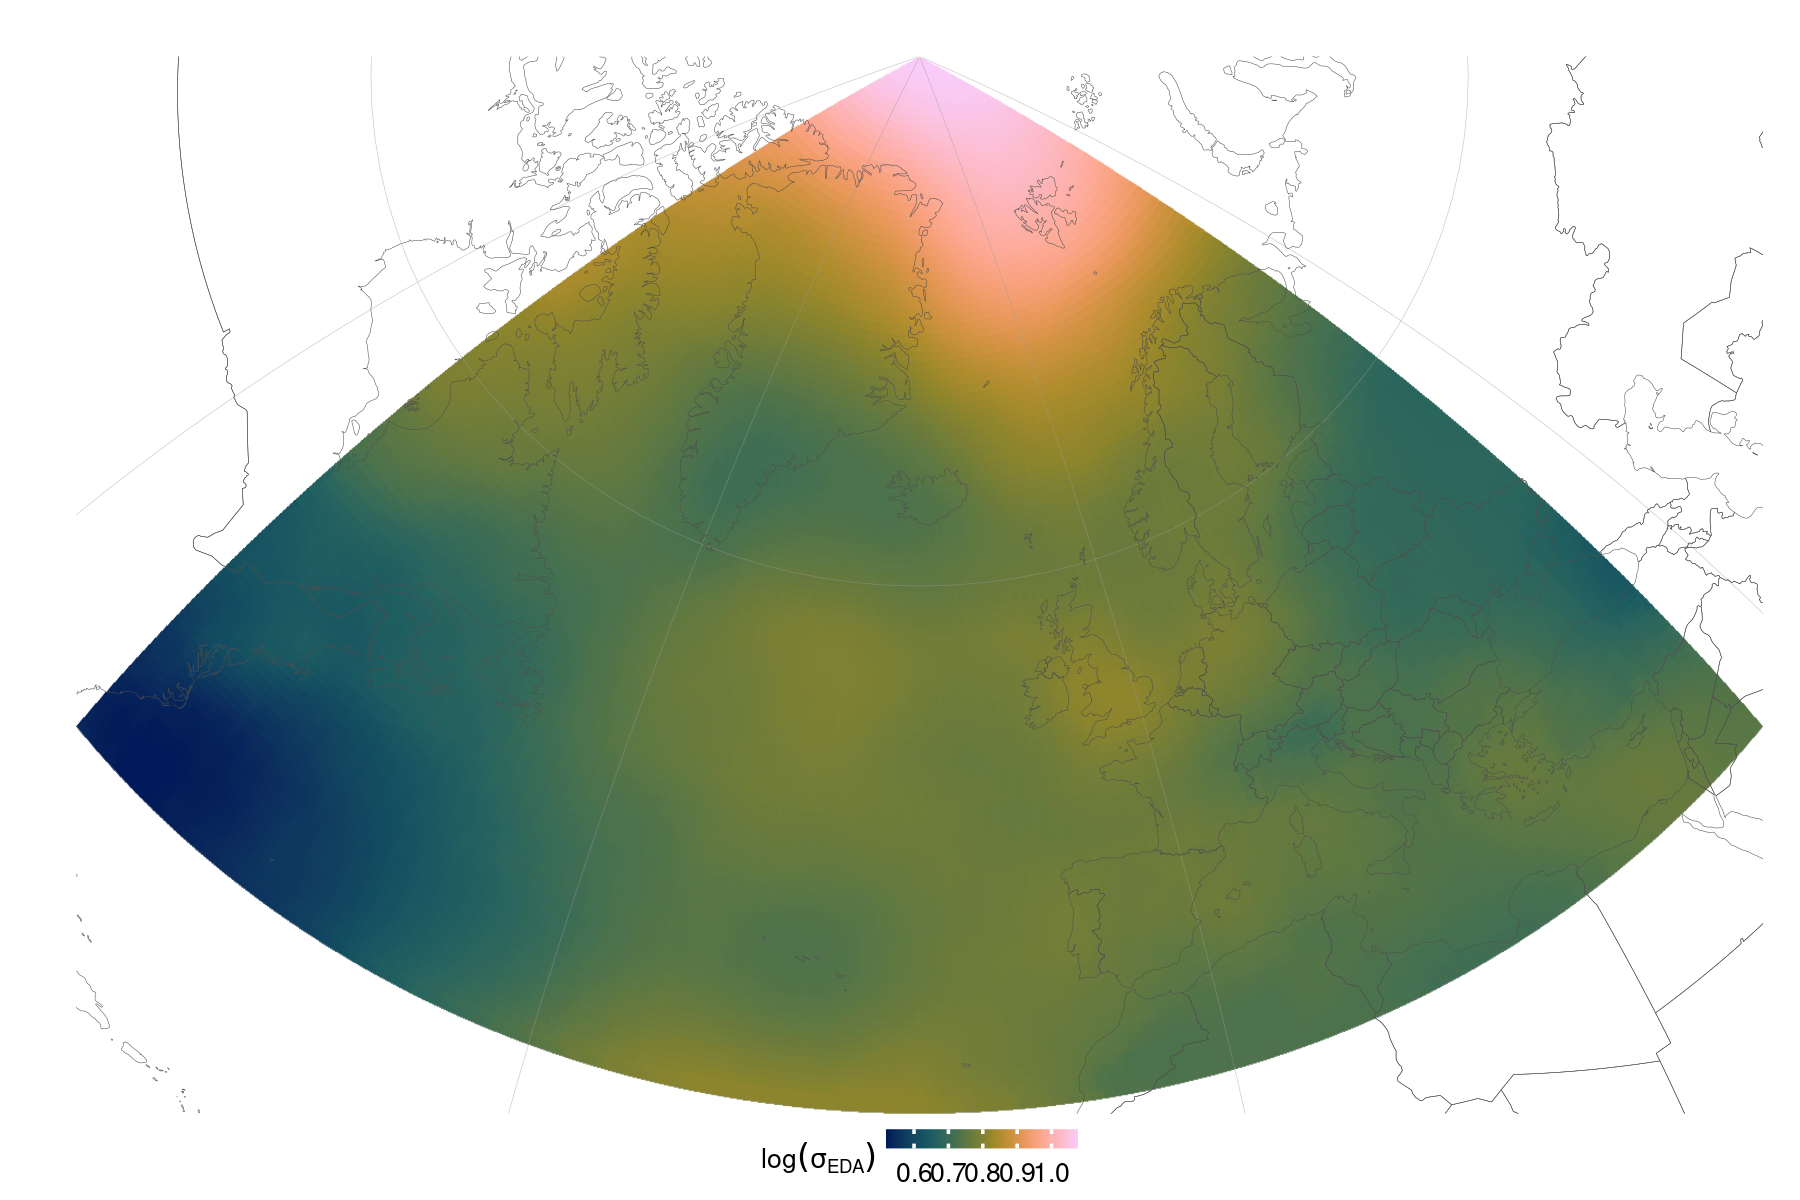

In [10]:
p <- plot_spatial(
    data = out, var_name = "sd_log_direct",
    legend_name = "$\\log(\\sigma_{EDA})$",
    show_graticule_labels = FALSE
) + THEME_PUB_LARGE +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        legend.box.spacing = unit(0, "cm"), # Remove space between legend and plot
        legend.margin = margin(t = -.5, unit = "cm") # Adjust top margin if needed
    ) #+ labs(title = "Stat. Model Fit")
p


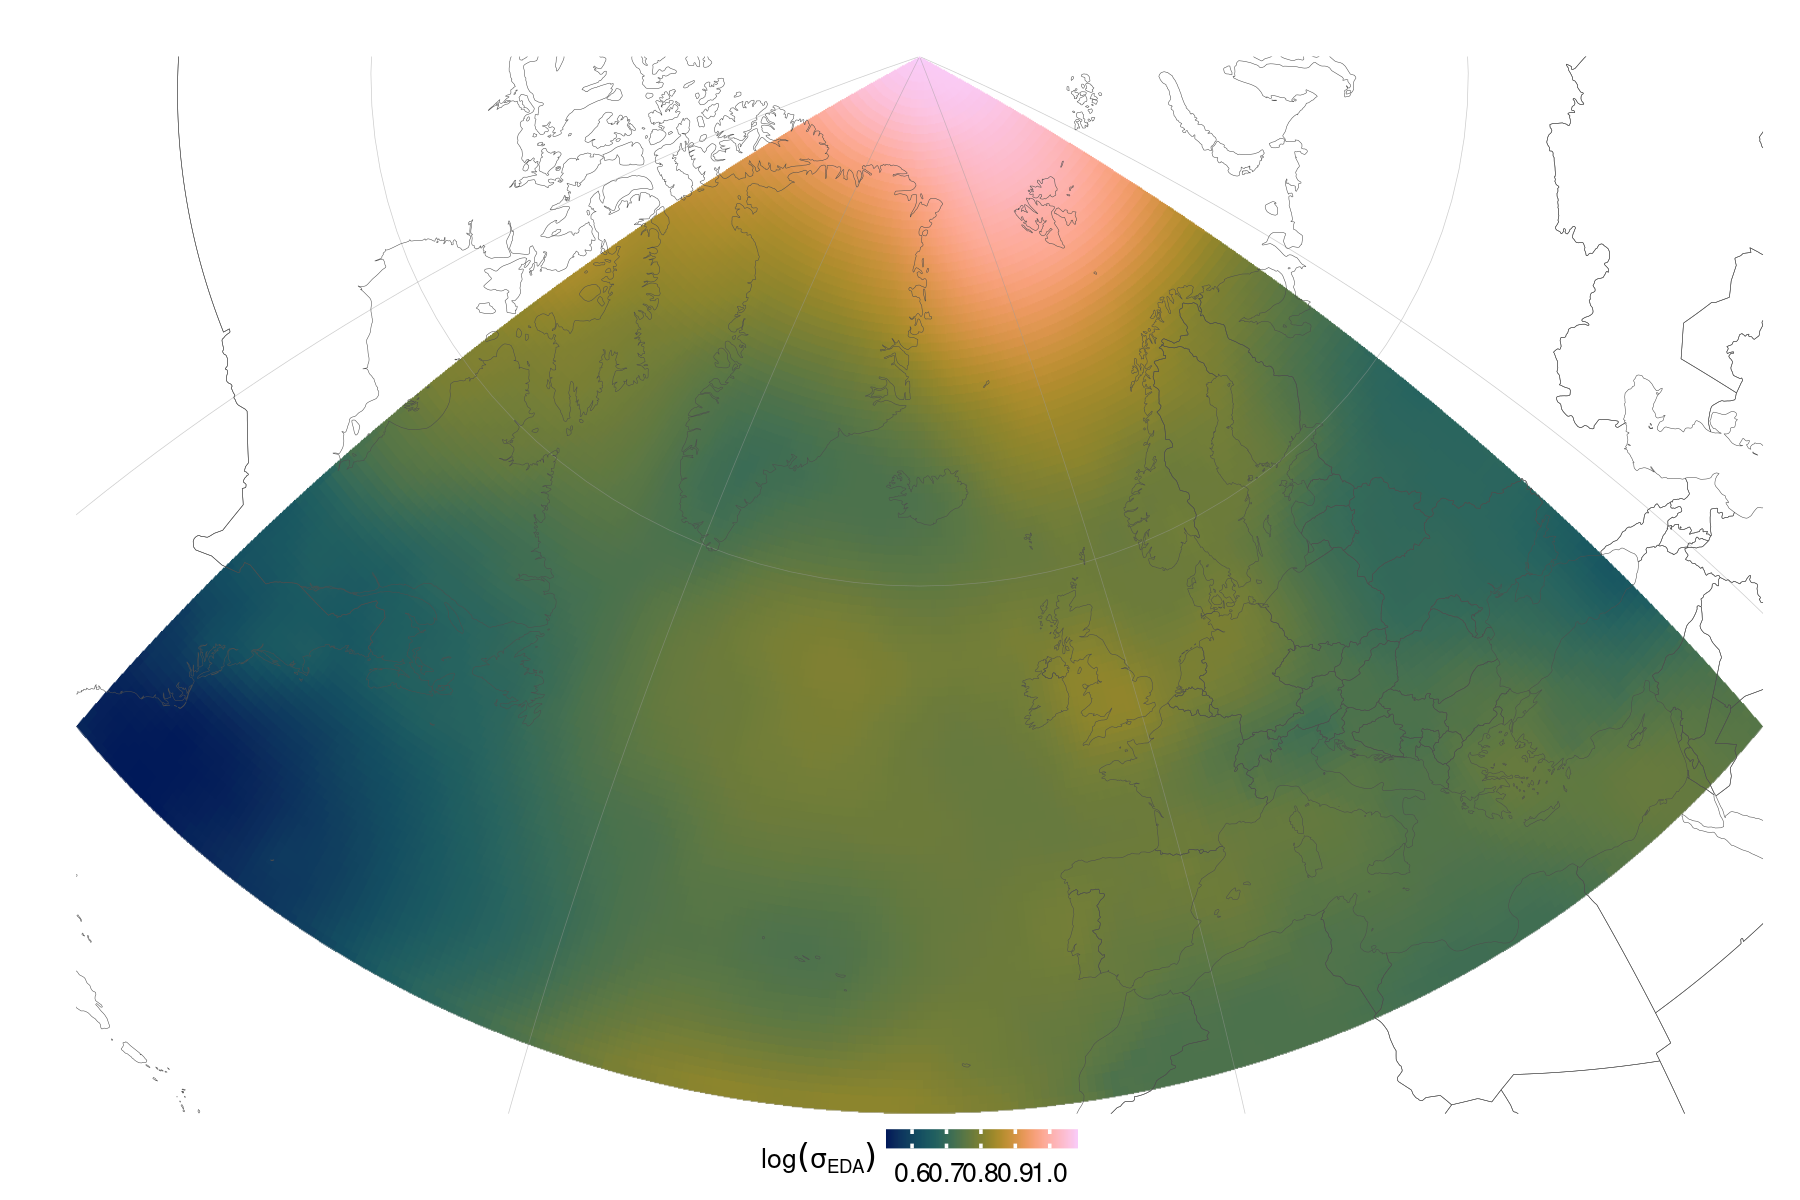

In [11]:
p <- plot_spatial(
    data = out, var_name = "sd_log_from_members",
    legend_name = "$\\log(\\sigma_{EDA})$",
    show_graticule_labels = FALSE
) + THEME_PUB_LARGE +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        legend.box.spacing = unit(0, "cm"), # Remove space between legend and plot
        legend.margin = margin(t = -.5, unit = "cm") # Adjust top margin if needed
    ) #+ labs(title = "Stat. Model Fit")
p


In [14]:
out$diff <- out$sd_log_from_members - out$sd_log_direct
p <- plot_spatial(
    data = out, var_name = "diff",
    legend_name = "$\\log(\\sigma_{EDA})$",
    show_graticule_labels = FALSE
) + THEME_PUB_LARGE +
    theme(
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        legend.box.spacing = unit(0, "cm"), # Remove space between legend and plot
        legend.margin = margin(t = -.5, unit = "cm") # Adjust top margin if needed
    ) #+ labs(title = "Stat. Model Fit")


pdf 
  2

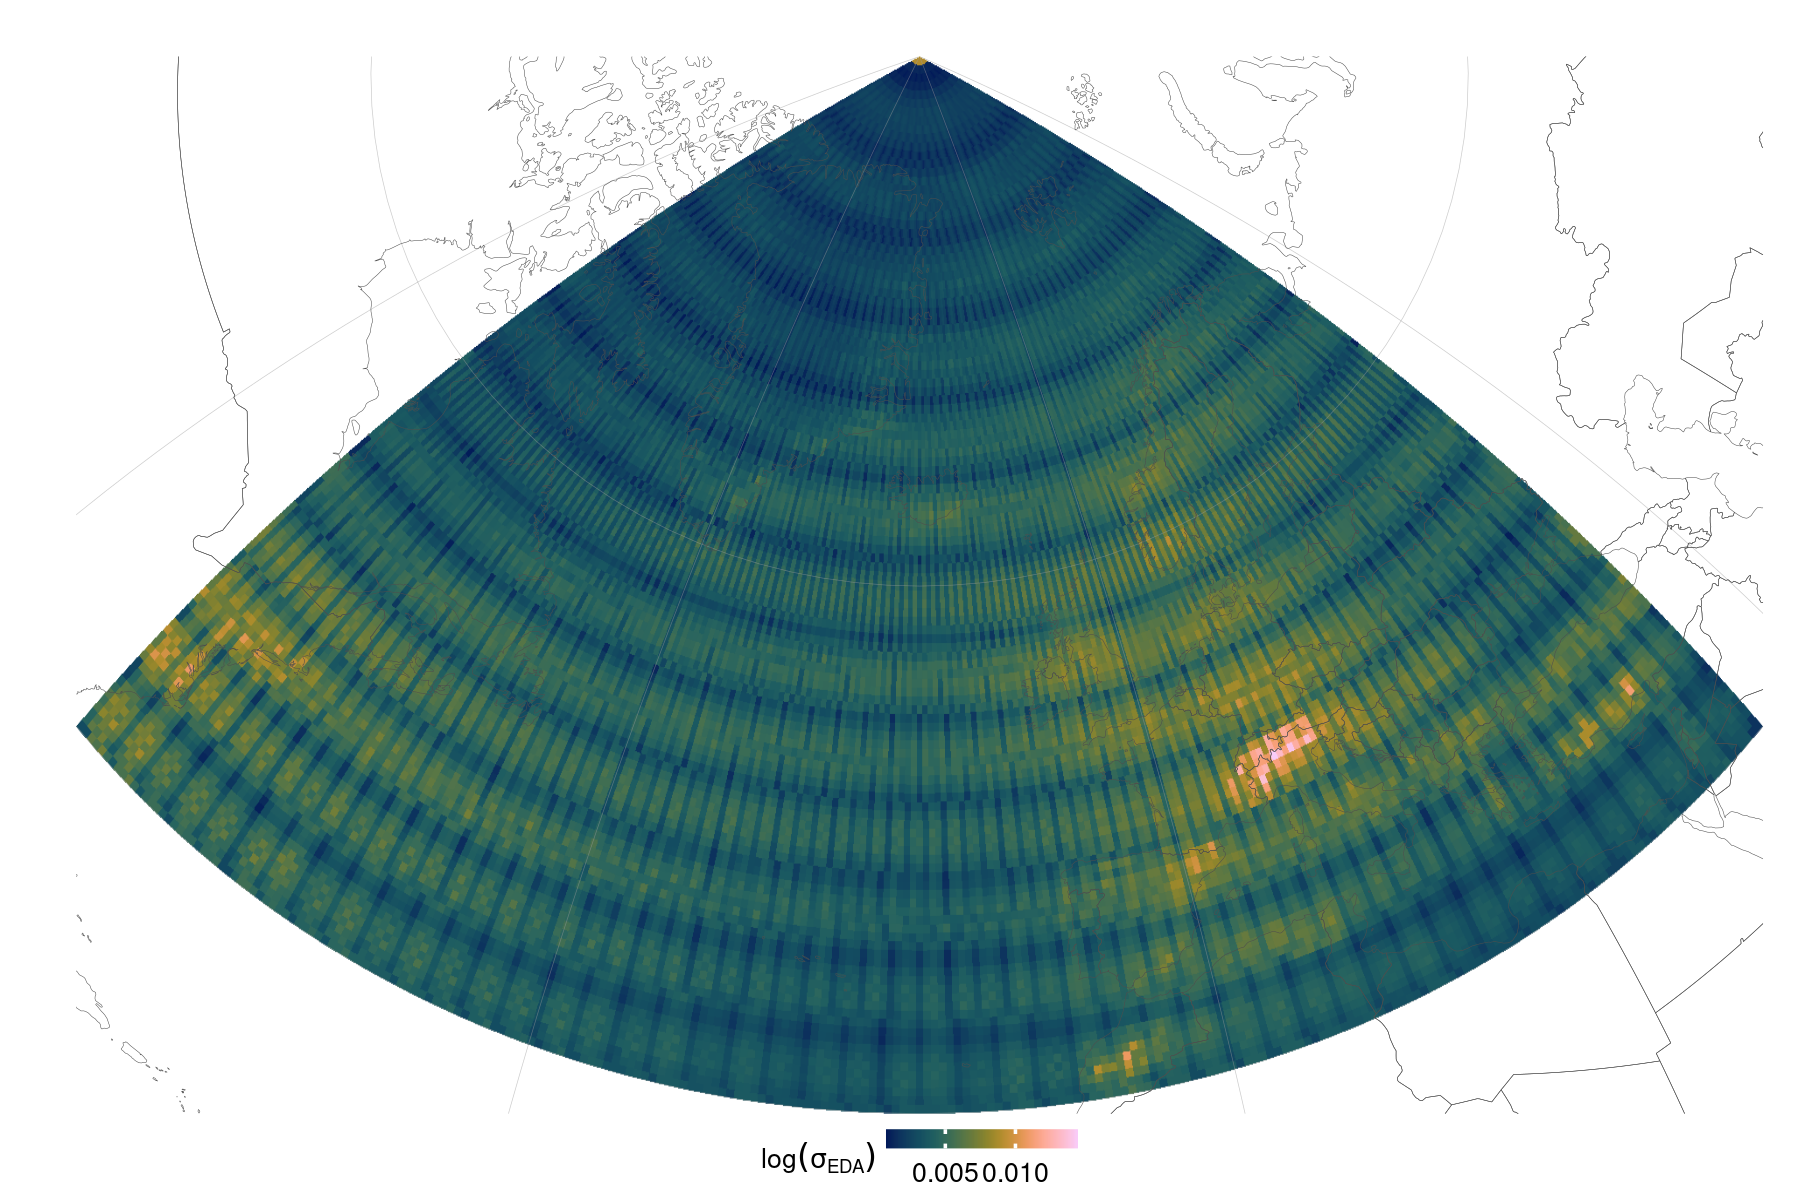

In [16]:
p
save_plot(p, "Checkerboard.pdf", width = 5, height = 4)


In [23]:
wgrid <- seq(0.5, 5, by = 0.01)

spec <- out %>%
    arrange(lat, lon) %>%
    group_by(lat) %>%
    summarise(
        spec = list({
            y <- diff
            n <- length(y)
            dx <- mean(diff(lon))

            fftv <- fft(y)
            power <- Mod(fftv)^2

            k <- 2:floor(n / 2)
            wavelength <- 1 / (k / (n * dx))

            ok <- wavelength >= 0.5 & wavelength <= 5

            approx(
                x = wavelength[ok],
                y = power[k][ok],
                xout = wgrid,
                rule = 2
            )$y
        }),
        .groups = "drop"
    ) %>%
    mutate(wavelength = list(wgrid)) %>%
    unnest(c(wavelength, spec)) %>%
    rename(power = spec)

p_spec <- ggplot(spec, aes(wavelength, lat, fill = power)) +
    geom_tile() +
    scale_fill_viridis_c() +
    labs(
        x = "Wavelength (deg lon)",
        y = "Latitude",
        fill = "Power"
    ) +
    theme_minimal()


pdf 
  2

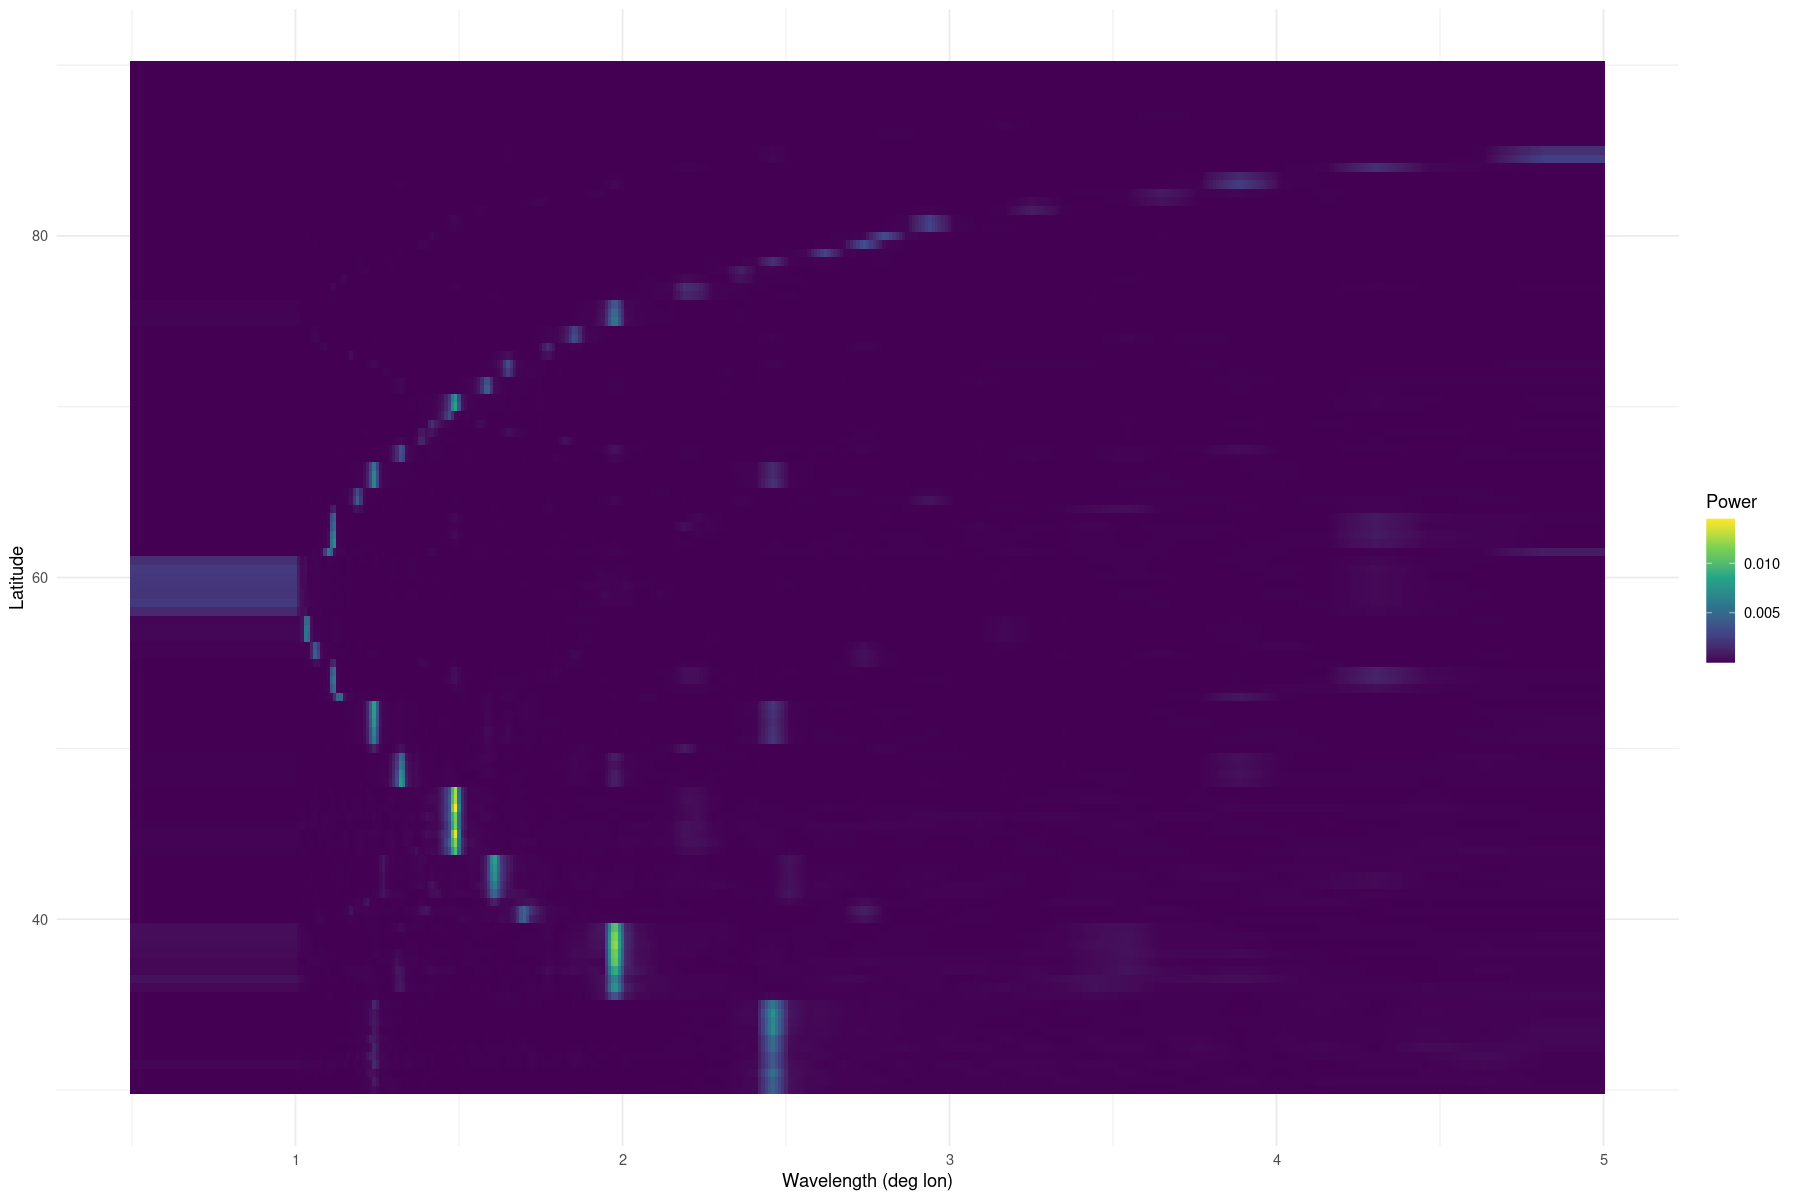

In [24]:
p_spec
save_plot(p_spec, "Checkerboard_Spectrum.pdf", width = 6, height = 4)
